In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
import scipy as sp
pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [15]:
#changes to be made -->
# search for temp and make those changes
# errorbar, change x and y to match in later graphs

In [16]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# DATA CLEANING AND WRANGLING

### Data Cleaning

In [17]:
# DF1 = Total and facet scores, and score per question
df00 = pd.read_csv('Indian Risk Literacy DYNATA_normal launch.csv')
df00 = df00[26:].copy()

df01 = pd.read_csv('Indian Risk Literacy DYNATA_normal launch_2.csv')[3822+26:]
df01 = df01.loc[ (df01["Q15a"] != "< INR 500,000") & (df01["Q15a"] != "INR 500,001 – INR 15,00,000") ].copy()
df00 = pd.concat([df00, df01], axis = 0)

# drop na in responses
df0 = df00.dropna(subset = df00.columns[19:77])

# removing students
df0 = df0.loc[ ~(df0["Q4a"] == "Student")].copy()

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df0[ques] = df0[ques].astype(str).replace(dict)
df0["Q8_std"] = df0[matrix].std(axis = 1)
df0 = df0.loc[ df0["Q8_std"] != 0].copy()

# attention check
df0 = df0.loc[ df0["Attention Check"] == "Vase"].copy()

# <0.5 median time of completion filtered
df0["Duration (in seconds)"] = df0["Duration (in seconds)"].astype("Int64")
median = df0["Duration (in seconds)"].astype("Int64").median()
df0 = df0.loc[ df0["Duration (in seconds)"] > median*0.5].copy()


In [18]:
df1 = df0.iloc[26:, 19:78].copy().reset_index(drop = True)
df1.insert(0, "ResponseId",0)
df1["ResponseId"] = df0["ResponseId"][26:].reset_index(drop = True).copy()
df1

ResponseId      Q1  Q2                                    Q3  \
0    R_4Dvu7ZttFgPENwR    Male  63                 Post-Graduate Program   
1    R_9s10NPIoxiHRAkx    Male  21  Secondary School (11th to 12th Std.)   
2    R_4AY9PEqIAgaYkuZ  Female  31                 Post-Graduate Program   
3    R_2dh1JGHNy9Qf3Sc  Female  27                 Post-Graduate Program   
4    R_9CZXmRgckGDCvLU  Female  25                 Post-Graduate Program   
..                 ...     ...  ..                                   ...   
631  R_9rPx1VMYf9pDm90    Male  42                 Post-Graduate Program   
632  R_4VIn9gXo6RpHUHL    Male  28                 Post-Graduate Program   
633  R_9dEoMkdzPwOt7HB  Female  34                 Post-Graduate Program   
634  R_9rZOEsJsyAejARq  Female  31                 Post-Graduate Program   
635  R_9CmzaonDBqfMV2l    Male  29                      Ph.D. and higher   

                             Q4a                    Q4.5_4  \
0                       Salaried     Low salary structure.   
1                       Salaried                      life   
2                       Salaried           Financial risk    
3                       Salaried                Pollution    
4                       Salaried             job security    
..                           ...                       ...   
631                     Salaried                     Life    
632                     Salaried  Starting a new business    
633                     Salaried                   Health    
634  Entrepreneur/Business Owner             Life's goals    
635                     Salaried                  Climate    

                  Q4.5_5                      Q4.5_6  \
0    More expensiveness.  Unable to save for future.   
1                  money                     and you   
2        Job insecurity              Climate change    
3                Failure              Not successful   
4             inflation              climate change    
..                   ...                         ...   
631         Health issue                        Job    
632     Father's health                    Diabetes    
633                 Time                  Pollution    
634          Investment                 Current job    
635              Future                          Job   

                           Q5_1                     Q6 - changed  Q8_1  Q8_2  \
0    0 (unwilling to take risk)                  Some experience     5     5   
1      7 (willing to take risk)         Definitely no experience     6     6   
2                             6           Rather much experience     4     6   
3                             6         Rather little experience     6     5   
4                             6  Definitely very much experience     6     6   
..                          ...                              ...   ...   ...   
631                           5           Rather much experience     5     5   
632                           5           Rather much experience     5     5   
633                           6           Rather much experience     5     5   
634    7 (willing to take risk)  Definitely very much experience     5     6   
635    7 (willing to take risk)           Rather much experience     5     3   

     Q8_3  Q8_4  Q8_5  Q8_6  Q8_7  Q8_8 Q9b_1 Q9b_4 Q9b_10 Q9b_5 Q9b_11  \
0       6     5     5     6     3     2    75    20      0     0      0   
1       6     6     6     3     2     6     0     0      0     0      0   
2       5     6     4     5     6     5    20    10      0     0      4   
3       6     5     6     4     4     4     7     4      6    15      3   
4       6     4     5     5     6     6    10    10      0    10      0   
..    ...   ...   ...   ...   ...   ...   ...   ...    ...   ...    ...   
631     5     5     5     5     4     5     5    10     10     0      0   
632     4     5     6     5     5     4    20    10      0     0      0   
633     5     5     4     4     4     4     5

In [19]:
df1[["ResponseId", "psid"]].to_csv("Indian Risk Literacy Survey_Dynata_Eligible IDs.csv")

## Demographics

In [7]:
df1["age"] = df1["Q2"].astype(int).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df1["age_rec"] = np.where( (df1["age"] >= 18) & (df1["age"] <= 35), 2,
                          np.where( (df1["age"] >= 36) & (df1["age"] <= 55), 3,
                                   np.where( (df1["age"] >= 56), 4, 0
                                           )
                                  )
                         )


# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df1["isced"] = np.where(df1["Q3"] == "Post-Graduate Program", 1,
                        np.where(df1["Q3"] == "Undergraduate Program", 2,
                                 np.where(df1["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df1["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df1["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df1["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df1["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df1["income"] = np.where(df1["Q15a"] == "< INR 500,000", 1,
                         np.where(df1["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df1["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df1["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df1["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df1["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df1["wealth"] = df1["Q14b"]


In [8]:
df1["Q1"].count()

636

In [9]:
df1["Q1"].value_counts()

Q1
Male      332
Female    304
Name: count, dtype: int64

In [10]:
df1["Q3"].value_counts()

Q3
Undergraduate Program                   197
Secondary School (11th to 12th Std.)    177
Post-Graduate Program                   173
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         14
M.Phil.                                  11
Name: count, dtype: int64

In [11]:
df1["isced"].value_counts()

isced
2    232
3    206
1    198
Name: count, dtype: int64

In [12]:
df1["Q4a"].value_counts()

Q4a
Salaried                       446
Entrepreneur/Business Owner    114
Currently not employed          65
Retired                         11
Name: count, dtype: int64

In [13]:
df1["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]]

Q15a
< INR 500,000                    183
INR 500,001 – INR 15,00,000      184
INR 1500,001 – INR 30,00,000     106
INR 30,00,001 – INR 50,00,000     70
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   41
Name: count, dtype: int64

In [14]:
df1["income"].value_counts().sort_index()

#   < INR 500,000                      --> 1
#     INR 500,001 – INR 15,00,000      --> 2
#     INR 1500,001 – INR 30,00,000     --> 3
#     INR 30,00,001 – INR 50,00,000    --> 4
#     INR 50,00,001 – INR 75,00,000    --> 5
#   > INR 75,00,000                    --> 5

income
1    183
2    184
3    106
4     68
5     52
6     40
Name: count, dtype: int64

In [5]:
#WEALTH 
sns.displot(data = list(df1["Q14b"].astype(int)), kind = "kde")

NameError: name 'df1' is not defined

## Questions

In [11]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df1[ matchCol ] = 0

df1.columns

Index(['ResponseId', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_5', 'Q9b_11', 'Q9b_12',
       'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b',
       'Q11a_1', 'Q11a_2', 'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4',
       'Q11b_5', 'Q11c', 'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a',
       'Q13b', 'Q13c', 'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1',
       'Q14c', 'Q54', 'Q57', 'Q58', 'Q15a', 'psid', 'age', 'age_rec', 'isced',
       'income', 'wealth', 'q8_2_1', 'q8_2_2', 'q8_2_3', 'q8_2_4', 'q8_2_5',
       'q8_3', 'q8_4', 'q8_5berlin_1', 'q8_5london_1', 'q8_5paris_1', 'q8_6',
       'q8_7', 'q9_1_1', 'q9_2_1', 'q9_3', 'q10_1_1', 'q10_2_1', 'q10_3_1',
       'q10_4'],
      dtype='object')

In [12]:
df1["q8_2_1"] = np.where(df1["Q11b_1"] == "No", 1, 2)
df1["q8_2_2"] = np.where(df1["Q11b_2"] == "No", 1, 2)
df1["q8_2_3"] = np.where(df1["Q11b_3"] == "No", 1, 2)
df1["q8_2_4"] = np.where(df1["Q11b_4"] == "No", 1, 2)
df1["q8_2_5"] = np.where(df1["Q11b_5"] == "No", 1, 2)

df1["q8_3"] = np.where(df1["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df1["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df1["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df1["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df1["q8_4"] = np.where(df1["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df1["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df1["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df1["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [13]:
df1["q8_4"].value_counts()

q8_4
3    15
2    11
1     9
4     9
Name: count, dtype: int64

In [14]:
df1["q8_5berlin_1"] = np.where(df1["Q11a_1"].astype(int) == 1, 1, 2)
df1["q8_5london_1"] = np.where(df1["Q11a_1"].astype(int) == 1, 1, 2)
df1["q8_5paris_1"] = np.where(df1["Q11a_1"].astype(int) == 1, 1, 2)

df1["q8_6"] = np.where(df1["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df1["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df1["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df1["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df1["q8_7"] = np.where(df1["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df1["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df1["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df1["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df1["q9_1_1"] = df1["Q14a"].copy()
df1["q9_2_1"] = df1["Q14b.1"].copy()

df1["q9_3"] = np.where(df1["Q14c"] == "Crosicol", 1,
                          np.where(df1["Q14c"] == "Hertinol", 2,
                                   np.where(df1["Q14c"] == "They are equal", 3,
                                            np.where(df1["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [15]:
df1["q9_2_1"].value_counts()

q9_2_1
20     26
60      4
40      3
50      2
10      1
100     1
55      1
Name: count, dtype: int64

In [16]:
df1["q10_1_1"] = df1["Q13a"].copy()
df1["q10_2_1"] = df1["Q13b"].copy()
df1["q10_3_1"] = df1["Q13c"].copy()

df1["q10_4"] = np.where(df1["Q13d"] == "9 out of 59", 1,
                          np.where(df1["Q13d"] == "9 out of 10", 2,
                                   np.where(df1["Q13d"] == "59 out of 1000", 3,
                                            np.where(df1["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [17]:
df1["q10_4"].value_counts()

q10_4
2    14
3    12
4     7
0     6
1     5
Name: count, dtype: int64

In [18]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5", "uncertainty1", "uncertainty2", "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5", "graph1", "graph2", "graph3", "riskcalculation1", "riskcalculation2", "riskcalculation3", "riskcalculation4"]
df1[scoreColumns] = 0

In [19]:
# Assigning scores

def scoring1(df1Facet):
    df1Facet.loc[ df1Facet["q8_2_1"] == 2, "certainty1"] = 1
    df1Facet.loc[ df1Facet["q8_2_2"] == 2, "certainty2"] = 1
    df1Facet.loc[ df1Facet["q8_2_3"] == 2, "certainty3"] = 1
    df1Facet.loc[ df1Facet["q8_2_4"] == 2, "certainty4"] = 1
    df1Facet.loc[ df1Facet["q8_2_5"] == 2, "certainty5"] = 1

    df1Facet.loc[ df1Facet["q8_3"] == 1, "uncertainty1"] = 1
    df1Facet.loc[ df1Facet["q8_4"] == 4, "uncertainty2"] = 1

    df1Facet.loc[ df1Facet["q8_5berlin_1"] == 2, "numeracy1"] = 1
    df1Facet.loc[ df1Facet["q8_5london_1"] == 1, "numeracy2"] = 1
    df1Facet.loc[ df1Facet["q8_5paris_1"] == 1, "numeracy3"] = 1
    df1Facet.loc[ df1Facet["q8_6"] == 1, "numeracy4"] = 1
    df1Facet.loc[ df1Facet["q8_7"] == 4, "numeracy5"] = 1

    df1Facet.loc[ df1Facet["q9_1_1"] == 25, "graph1"] = 1
    df1Facet.loc[ df1Facet["q9_2_1"] == 20, "graph2"] = 1
    df1Facet.loc[ df1Facet["q9_3"] == 3, "graph3"] = 1

    df1Facet.loc[ df1Facet["q10_1_1"] == 500, "riskcalculation1"] = 1
    df1Facet.loc[ df1Facet["q10_2_1"] == 10, "riskcalculation2"] = 1
    df1Facet.loc[ (df1Facet["q10_3_1"] == 0.1) | (df1Facet["q10_3_1"] == ".1") | (df1Facet["q10_3_1"] == ",1") , "riskcalculation3"] = 1
    df1Facet.loc[ df1Facet["q10_4"] == 1, "riskcalculation4"] = 1

    # Assigning total scores
    #df1Facet["Certainty score_5"] = df1Facet["certainty1"] + df1Facet["certainty2"] + df1Facet["certainty3"] + df1Facet["certainty4"] + df1Facet["certainty5"]
    #df1Facet["Uncertainty score_5"] = df1Facet["uncertainty1"] + df1Facet["uncertainty2"]

    #df1Facet["Number Comprehension score_5"] = df1Facet["numeracy1"] + df1Facet["numeracy2"] + df1Facet["numeracy3"] + df1Facet["numeracy4"] + df1Facet["numeracy5"]
    #df1Facet["Graph Comprehension score_5"] = df1Facet["graph1"] + df1Facet["graph2"] + df1Facet["graph3"]

    #df1Facet["Calculation score_4"] = df1Facet["riskcalculation1"] + df1Facet["riskcalculation2"] + df1Facet["riskcalculation3"] + df1Facet["riskcalculation4"]

    #df1Facet["Total Score_19"] = df1Facet["Certainty score_5"] + df1Facet["Uncertainty score_5"] + df1Facet["Number Comprehension score_5"] + df1Facet["Graph Comprehension score_5"] + df1Facet["Calculation score_4"]

    return df1Facet

In [20]:
df1Facet = df1.groupby(["ResponseId"]).progress_apply(scoring1)

100%|█████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 303.75it/s]


In [21]:
df1Facet

ResponseId      Q1  Q2  \
ResponseId                                            
R_1dRIfOJjkXVM1nL 20  R_1dRIfOJjkXVM1nL  Female  23   
R_2dh1JGHNy9Qf3Sc 43  R_2dh1JGHNy9Qf3Sc  Female  27   
R_2jiyT9teVIVHpQy 36  R_2jiyT9teVIVHpQy    Male  25   
R_37jpqSSD0cmMBQQ 4   R_37jpqSSD0cmMBQQ  Female  65   
R_3QLPNhaVQBnJsSe 12  R_3QLPNhaVQBnJsSe    Male  45   
R_40GWAL4WdQi5VAS 11  R_40GWAL4WdQi5VAS  Female  44   
R_4176twZZuUqgV9m 8   R_4176twZZuUqgV9m  Female  35   
R_4AY9PEqIAgaYkuZ 42  R_4AY9PEqIAgaYkuZ  Female  31   
R_4CyH4vrwFkIMDVD 34  R_4CyH4vrwFkIMDVD    Male  31   
R_4Dvu7ZttFgPENwR 39  R_4Dvu7ZttFgPENwR    Male  63   
R_4FsteJ71URQ4F4U 18  R_4FsteJ71URQ4F4U    Male  34   
R_4GJIH6GbqzLPmEv 14  R_4GJIH6GbqzLPmEv  Female  50   
R_4HuasZgAdjFEHk8 30  R_4HuasZgAdjFEHk8    Male  57   
R_4ILQ6jRhbVna8kN 9   R_4ILQ6jRhbVna8kN  Female  31   
R_4IaSxXGv1CohFKJ 7   R_4IaSxXGv1CohFKJ    Male  32   
R_4L6m1FU0Ujmh3V7 1   R_4L6m1FU0Ujmh3V7    Male  19   
R_4McIMWBwCH9AFnv 28  R_4McIMWBwCH9AFnv  Female  21   
R_4QFTiizSKJc7z89 0   R_4QFTiizSKJc7z89  Female  34   
R_4efA0IivV0kgbW4 5   R_4efA0IivV0kgbW4    Male  43   
R_4fklajzbcuU4NST 17  R_4fklajzbcuU4NST    Male  29   
R_4gbu4eNareZsG1n 26  R_4gbu4eNareZsG1n  Female  51   
R_4hT42B7PXqjid4p 33  R_4hT42B7PXqjid4p  Female  21   
R_4hmcVnKZPIvDOa7 31  R_4hmcVnKZPIvDOa7    Male  42   
R_4iP9ZyO9BmRTMnR 3   R_4iP9ZyO9BmRTMnR    Male  53   
R_4lEUpdznwWtpRu1 24  R_4lEUpdznwWtpRu1  Female  57   
R_4lhh2fUgLjRDBoW 35  R_4lhh2fUgLjRDBoW    Male  37   
R_4lz68e8z2NuRRnB 13  R_4lz68e8z2NuRRnB  Female  65   
R_4rqHwH5DM0AMTLj 37  R_4rqHwH5DM0AMTLj    Male  29   
R_4ziRnglDZQo2B0t 6   R_4ziRnglDZQo2B0t  Female  40   
R_93a68YKbkrwr9yI 25  R_93a68YKbkrwr9yI  Female  62   
R_93k9HjrDvW0Xd4d 41  R_93k9HjrDvW0Xd4d    Male  42   
R_94RdOE5ZgRNG4EN 23  R_94RdOE5ZgRNG4EN    Male  34   
R_97I7fCImWYfF0c1 16  R_97I7fCImWYfF0c1    Male  37   
R_9CE2lLvpyPaeyKL 2   R_9CE2lLvpyPaeyKL    Male  30   
R_9DO5s0JxPsoShVq 10  R_9DO5s0JxPsoShVq    Male  65   
R_9KkHAUQVKsGiBhe 32  R_9KkHAUQVKsGiBhe  Female  26   
R_9OVVcpK6sOQlOIS 38  R_9OVVcpK6sOQlOIS    Male  29   
R_9OjW44KK2eoxYq6 22  R_9OjW44KK2eoxYq6    Male  25   
R_9PGkGeha7t3DUrf 15  R_9PGkGeha7t3DUrf    Male  30   
R_9WK1oFSxYtmb82d 21  R_9WK1oFSxYtmb82d    Male  26   
R_9jT8PNfeoMVzXkt 29  R_9jT8PNfeoMVzXkt    Male  36   
R_9pbaa1ht3gisbyT 27  R_9pbaa1ht3gisbyT  Female  47   
R_9s10NPIoxiHRAkx 40  R_9s10NPIoxiHRAkx    Male  21   
R_9vdhG8DvdLvRPJ3 19  R_9vdhG8DvdLvRPJ3    Male  30   

                                                        Q3  \
ResponseId                                                   
R_1dRIfOJjkXVM1nL 20                 Undergraduate Program   
R_2dh1JGHNy9Qf3Sc 43                 Post-Graduate Program   
R_2jiyT9teVIVHpQy 36                 Undergraduate Program   
R_37jpqSSD0cmMBQQ 4                  Undergraduate Program   
R_3QLPNhaVQBnJsSe 12                 Post-Graduate Program   
R_40GWAL4WdQi5VAS 11                 Post-Graduate Program   
R_4176twZZuUqgV9m 8   Secondary School (11th to 12th Std.)   
R_4AY9PEqIAgaYkuZ 42                 Post-Graduate Program   
R_4CyH4vrwFkIMDVD 34                 Undergraduate Program   
R_4Dvu7ZttFgPENwR 39                 Post-Graduate Program   
R_4FsteJ71URQ4F4U 18                 Post-Graduate Program   
R_4GJIH6GbqzLPmEv 14                 Undergraduate Program   
R_4HuasZgAdjFEHk8 30                 Post-Graduate Program   
R_4ILQ6jRhbVna8kN 9                  Post-Graduate Program   
R_4IaSxXGv1CohFKJ 7                  Undergraduate Program   
R_4L6m1FU0Ujmh3V7 1   Secondary School (11th to 12th Std.)   
R_4McIMWBwCH9AFnv 28                 Post-Graduate Program   
R_4QFTiizSKJc7z89 0                       Ph.D. and higher   
R_4efA0IivV0kgbW4 5                  Undergraduate Program   
R_4fklajzbcuU4NST 17                 Post-Graduate Program   
R_4gbu4eNareZsG1n 26                 Post-Graduate Program   
R_4hT42B7PXqjid4p 33                 Undergraduate Program   
R_4hmcVnKZ

In [59]:
df1 = df1Facet.dropna().copy()

In [60]:
df1["Certainty_3"] = df1["certainty1"] + df1["certainty2"] + df1["certainty3"]
df1["RiskComprehension_4"] = df1["riskcalculation1"] + df1["riskcalculation2"] + df1["riskcalculation3"] + df1["riskcalculation4"]
df1["GraphLiteracy_3"] = df1["graph1"] + df1["graph2"] + df1["graph3"]
df1["Numeracy_3"] = df1["numeracy1"] + df1["numeracy2"] + df1["numeracy3"]
df1["Bayesianreasoning_1"] = df1["numeracy4"]
df1["TotalScore_14"] = df1["Certainty_3"] + df1["RiskComprehension_4"] + df1["GraphLiteracy_3"] + df1["Numeracy_3"] + df1["Bayesianreasoning_1"]

df1["Certainty_%"] = df1["Certainty_3"] / 3 * 100
df1["RiskComprehension_%"] = df1["RiskComprehension_4"] / 4 * 100
df1["GraphLiteracy_%"] = df1["GraphLiteracy_3"] / 3 * 100
df1["Numeracy_%"] = df1["Numeracy_3"] / 3 * 100
df1["Bayesianreasoning_%"] = df1["Bayesianreasoning_1"] / 1 * 100

df1["TotalScore_%"] = df1["TotalScore_14"] / 14 * 100


colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_3", "RiskComprehension_4", "GraphLiteracy_3",
          "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
          "TotalScore_14", "TotalScore_%",]

df2 = df1[colReq].copy()
df2

ResponseId  age  age_rec  isced  income  \
ResponseId                                                             
R_2dh1JGHNy9Qf3Sc 43  R_2dh1JGHNy9Qf3Sc   27        2      1       5   
R_2jiyT9teVIVHpQy 36  R_2jiyT9teVIVHpQy   25        2      2       3   
R_37jpqSSD0cmMBQQ 4   R_37jpqSSD0cmMBQQ   65        4      2       2   
R_3QLPNhaVQBnJsSe 12  R_3QLPNhaVQBnJsSe   45        3      1       3   
R_40GWAL4WdQi5VAS 11  R_40GWAL4WdQi5VAS   44        3      1       4   
R_4176twZZuUqgV9m 8   R_4176twZZuUqgV9m   35        2      3       6   
R_4AY9PEqIAgaYkuZ 42  R_4AY9PEqIAgaYkuZ   31        2      1       5   
R_4CyH4vrwFkIMDVD 34  R_4CyH4vrwFkIMDVD   31        2      2       2   
R_4Dvu7ZttFgPENwR 39  R_4Dvu7ZttFgPENwR   63        4      1       1   
R_4FsteJ71URQ4F4U 18  R_4FsteJ71URQ4F4U   34        2      1       4   
R_4GJIH6GbqzLPmEv 14  R_4GJIH6GbqzLPmEv   50        3      2       1   
R_4ILQ6jRhbVna8kN 9   R_4ILQ6jRhbVna8kN   31        2      1       3   
R_4IaSxXGv1CohFKJ 7   R_4IaSxXGv1CohFKJ   32        2      2       3   
R_4L6m1FU0Ujmh3V7 1   R_4L6m1FU0Ujmh3V7   19        2      3       2   
R_4McIMWBwCH9AFnv 28  R_4McIMWBwCH9AFnv   21        2      1       2   
R_4efA0IivV0kgbW4 5   R_4efA0IivV0kgbW4   43        3      2       1   
R_4fklajzbcuU4NST 17  R_4fklajzbcuU4NST   29        2      1       2   
R_4gbu4eNareZsG1n 26  R_4gbu4eNareZsG1n   51        3      1       2   
R_4hmcVnKZPIvDOa7 31  R_4hmcVnKZPIvDOa7   42        3      1       4   
R_4iP9ZyO9BmRTMnR 3   R_4iP9ZyO9BmRTMnR   53        3      1       4   
R_4lEUpdznwWtpRu1 24  R_4lEUpdznwWtpRu1   57        4      1       3   
R_4lhh2fUgLjRDBoW 35  R_4lhh2fUgLjRDBoW   37        3      1       4   
R_4lz68e8z2NuRRnB 13  R_4lz68e8z2NuRRnB   65        4      1       1   
R_4rqHwH5DM0AMTLj 37  R_4rqHwH5DM0AMTLj   29        2      1       3   
R_4ziRnglDZQo2B0t 6   R_4ziRnglDZQo2B0t   40        3      2       2   
R_93a68YKbkrwr9yI 25  R_93a68YKbkrwr9yI   62        4      2       1   
R_93k9HjrDvW0Xd4d 41  R_93k9HjrDvW0Xd4d   42        3      2       3   
R_94RdOE5ZgRNG4EN 23  R_94RdOE5ZgRNG4EN   34        2      1       2   
R_97I7fCImWYfF0c1 16  R_97I7fCImWYfF0c1   37        3      1       4   
R_9CE2lLvpyPaeyKL 2   R_9CE2lLvpyPaeyKL   30        2      1       2   
R_9DO5s0JxPsoShVq 10  R_9DO5s0JxPsoShVq   65        4      2       2   
R_9KkHAUQVKsGiBhe 32  R_9KkHAUQVKsGiBhe   26        2      2       3   
R_9OVVcpK6sOQlOIS 38  R_9OVVcpK6sOQlOIS   29        2      1       2   
R_9OjW44KK2eoxYq6 22  R_9OjW44KK2eoxYq6   25        2      1       3   
R_9WK1oFSxYtmb82d 21  R_9WK1oFSxYtmb82d   26        2      1       2   
R_9pbaa1ht3gisbyT 27  R_9pbaa1ht3gisbyT   47        3      2       1   
R_9s10NPIoxiHRAkx 40  R_9s10NPIoxiHRAkx   21        2      3       1   
R_9vdhG8DvdLvRPJ3 19  R_9vdhG8DvdLvRPJ3   30        2      1       6   

                        wealth  Certainty_3  RiskComprehension_4  \
ResponseId                                                         
R_2dh1JGHNy9Qf3Sc 43    560000            2                    0   
R_2jiyT9teVIVHpQy 36  10000000            3                    0   
R_37jpqSSD0cmMBQQ 4    7500000            2                    0   
R_3QLPNhaVQBnJsSe 12  34000000            3                    0   
R_40GWAL4WdQi5VAS 11  40000000            3                    0   
R_4176twZZuUqgV9m 8   20500000            2                    0   
R_4AY9PEqIAgaYkuZ 42  20000000            1                    0   
R_4CyH4vrwFkIMDVD 34    500000            1                    0   
R_4Dvu7ZttFgPENwR 39   1100000            3                    0   
R_4FsteJ71URQ4F4U 18   7000000            2                    0   
R_4GJIH6GbqzLPmEv 14        50            1                    0   
R_4ILQ6jRhbVna8kN 9   35000000            3                    0   
R_4IaSxXGv1CohFKJ 7    8000000            2                    0   
R_4L6m1FU0Ujmh3V7 1    1000000            1                    0   
R_4McIMWBwCH9AFnv 28    500000            2                 

<Axes: title={'center': 'Frequency of Scores'}, xlabel='TotalScore_14', ylabel='Frequency'>

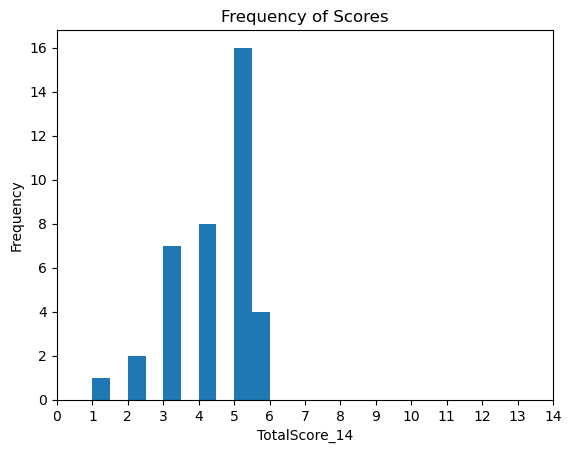

In [61]:
# The following graph represents frequency of each data point on "TotalScore_14" or the total score out of 19 questions across the sample.

df2['TotalScore_14'].plot(kind = 'hist', xticks = np.arange(0, 15, step=1), xlabel = 'TotalScore_14', title = 'Frequency of Scores' )

<Axes: title={'center': 'Absolute mean of scores for above data set'}>

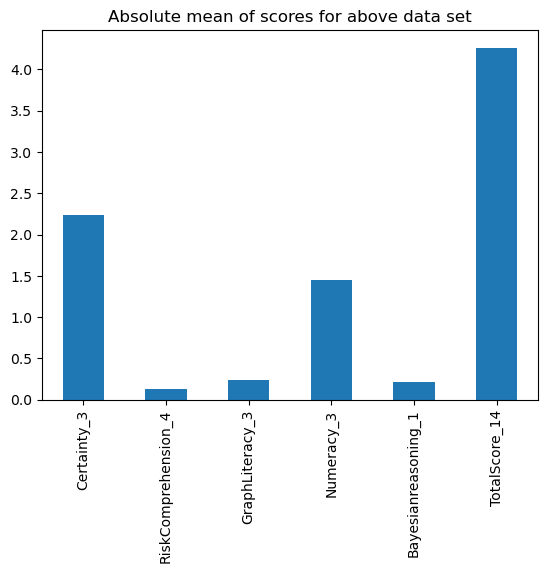

In [62]:
# Absolute mean scores for each facet

(df2[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0)).plot(kind = 'bar', title = 'Absolute mean of scores for above data set')

<Axes: title={'center': '% Mean of scores for above data set'}>

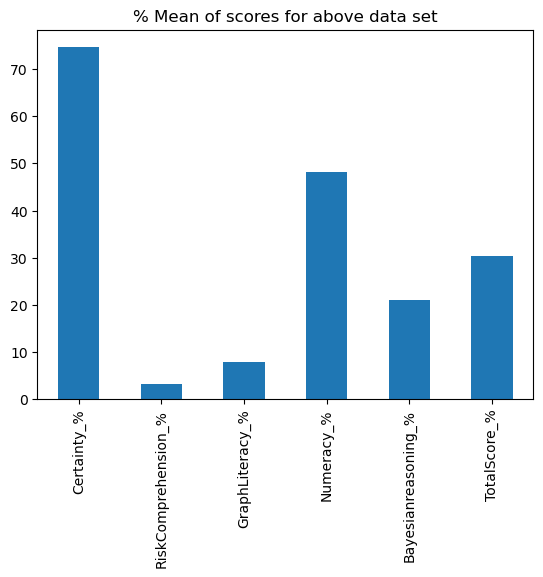

In [63]:
# Normalised mean scores for each facet

df2[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0).plot(kind = 'bar', title = '% Mean of scores for above data set')

In [64]:
# DF3 = Sorted by income

df3 = df2.sort_values(by = 'income')
df3 = df3.reset_index(drop = True)
df3.drop(df3[df3['income'] == 7].index, inplace = True)

df3

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0   R_4GJIH6GbqzLPmEv   50        3      2       1        50            1   
1   R_9s10NPIoxiHRAkx   21        2      3       1     30000            2   
2   R_4efA0IivV0kgbW4   43        3      2       1   2200000            3   
3   R_93a68YKbkrwr9yI   62        4      2       1   5000000            3   
4   R_4Dvu7ZttFgPENwR   63        4      1       1   1100000            3   
5   R_4lz68e8z2NuRRnB   65        4      1       1      2000            3   
6   R_9pbaa1ht3gisbyT   47        3      2       1   5000000            2   
7   R_9WK1oFSxYtmb82d   26        2      1       2   2000000            1   
8   R_4CyH4vrwFkIMDVD   31        2      2       2    500000            1   
9   R_9CE2lLvpyPaeyKL   30        2      1       2   5000000            2   
10  R_94RdOE5ZgRNG4EN   34        2      1       2    300000            2   
11  R_9DO5s0JxPsoShVq   65        4      2       2   1000000            0   
12  R_4L6m1FU0Ujmh3V7   19        2      3       2   1000000            1   
13  R_4McIMWBwCH9AFnv   21        2      1       2    500000            2   
14  R_37jpqSSD0cmMBQQ   65        4      2       2   7500000            2   
15  R_9OVVcpK6sOQlOIS   29        2      1       2    500000            3   
16  R_4gbu4eNareZsG1n   51        3      1       2    100000            3   
17  R_4ziRnglDZQo2B0t   40        3      2       2   1800000            3   
18  R_4fklajzbcuU4NST   29        2      1       2       100            3   
19  R_4rqHwH5DM0AMTLj   29        2      1       3         1            3   
20  R_93k9HjrDvW0Xd4d   42        3      2       3  10000000            3   
21  R_9KkHAUQVKsGiBhe   26        2      2       3   1500000            3   
22  R_9OjW44KK2eoxYq6   25        2      1       3         0            0   
23  R_4lEUpdznwWtpRu1   57        4      1       3    100000            1   
24  R_4IaSxXGv1CohFKJ   32        2      2       3   8000000            2   
25  R_4ILQ6jRhbVna8kN   31        2      1       3  35000000            3   
26  R_3QLPNhaVQBnJsSe   45        3      1       3  34000000            3   
27  R_2jiyT9teVIVHpQy   25        2      2       3  10000000            3   
28  R_4iP9ZyO9BmRTMnR   53        3      1       4   9000000            3   
29  R_4FsteJ71URQ4F4U   34        2      1       4   7000000            2   
30  R_97I7fCImWYfF0c1   37        3      1       4  10000000            3   
31  R_40GWAL4WdQi5VAS   44        3      1       4  40000000            3   
32  R_4lhh2fUgLjRDBoW   37        3      1       4    500000            3   
33  R_4hmcVnKZPIvDOa7   42        3      1       4   1000000            2   
34  R_2dh1JGHNy9Qf3Sc   27        2      1       5    560000            2   
35  R_4AY9PEqIAgaYkuZ   31        2      1       5  20000000            1   
36  R_4176twZZuUqgV9m   35        2      3       6  20500000            2   
37  R_9vdhG8DvdLvRPJ3   30        2      1       6  12500000            3   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                     0                1           1                    0   
1                     1                1           1                    0   
2                     0                1           1                    1   
3                     0                0           1                    1   
4                     0                1           1                    0   
5                     0                0           2                    0   
6                     0                0           2                    0   
7                     0                0           2                    1   
8                     0                0           2                    0   
9                     1                1           1                    0   
10                    0                0           2                    0   
11                    0                0           1                    0   
12    

<Axes: title={'center': 'Absolute mean score for each facet'}>

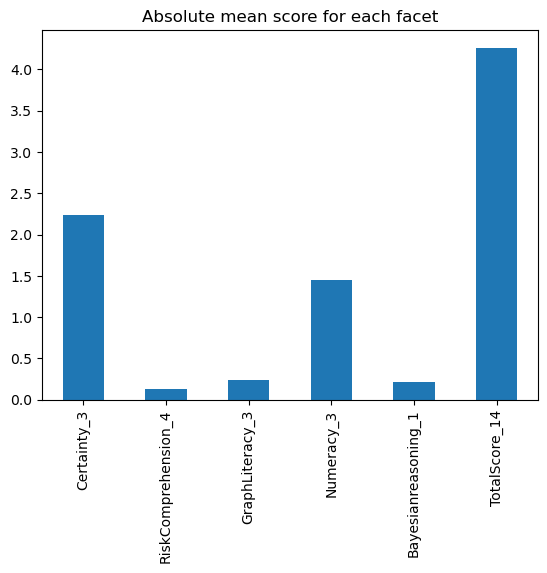

In [65]:
# Absolute mean score for each facet (Sort by Income)

df3[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0).plot(kind = 'bar', title = 'Absolute mean score for each facet')

<Axes: title={'center': '% Mean score for each facet'}>

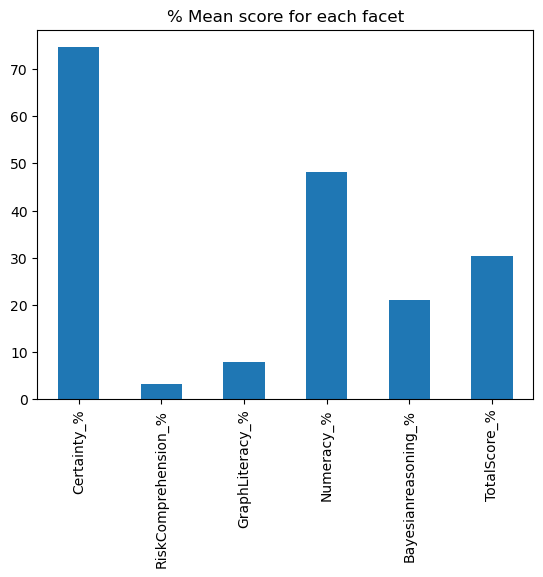

In [66]:
# Normalised mean score for each facet (Sort by Income)

(df3[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0)).plot(kind = 'bar', title = '% Mean score for each facet')

In [67]:
# Normalised mean of each facet as a numerical (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean()

Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
income                                                                  
1         80.952381             3.571429        19.047619   42.857143   
2         63.888889             2.083333         5.555556   47.222222   
3         77.777778             2.777778         7.407407   48.148148   
4         88.888889             8.333333         0.000000   61.111111   
5         50.000000             0.000000         0.000000   33.333333   
6         83.333333             0.000000        16.666667   50.000000   

        Bayesianreasoning_%  TotalScore_%  
income                                     
1                 28.571429     33.673469  
2                 16.666667     26.785714  
3                 22.222222     30.952381  
4                 33.333333     36.904762  
5                  0.000000     17.857143  
6                  0.000000     32.142857

In [68]:
# Count of responses for each category (sorted by income)

df3.groupby('income')[['ResponseId']].count()

ResponseId
income            
1                7
2               12
3                9
4                6
5                2
6                2

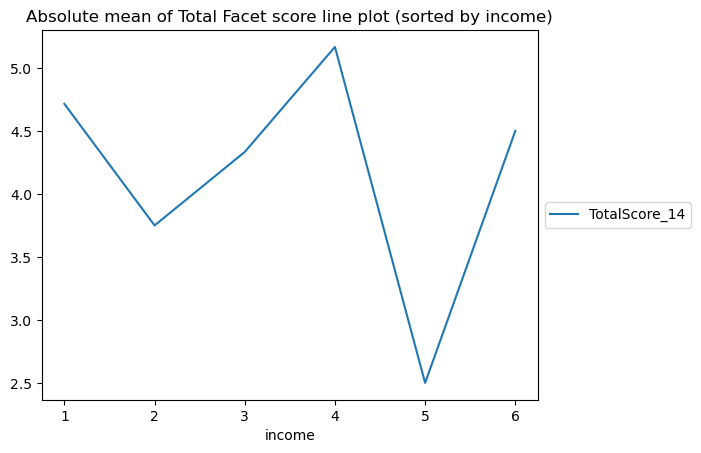

In [69]:
# Absolute mean of Total Facet score line plot (sorted by income)

df3.groupby('income')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute mean of Total Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

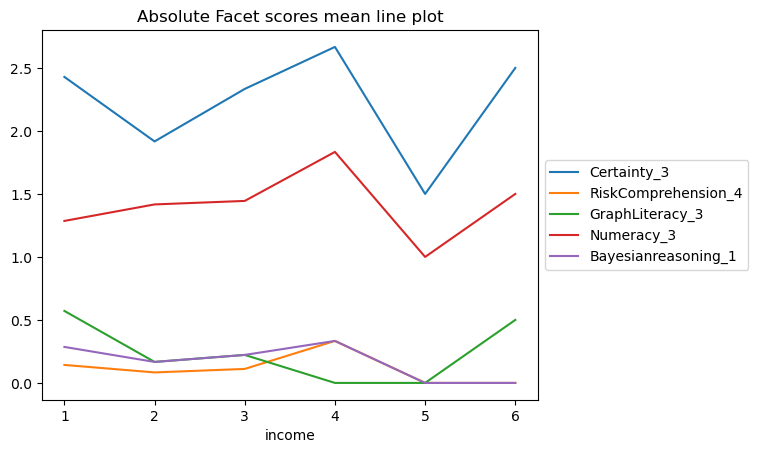

In [70]:
# Absolute mean of each Facet score line plot (sorted by income)

df3.groupby('income')[['Certainty_3','RiskComprehension_4','GraphLiteracy_3','Numeracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

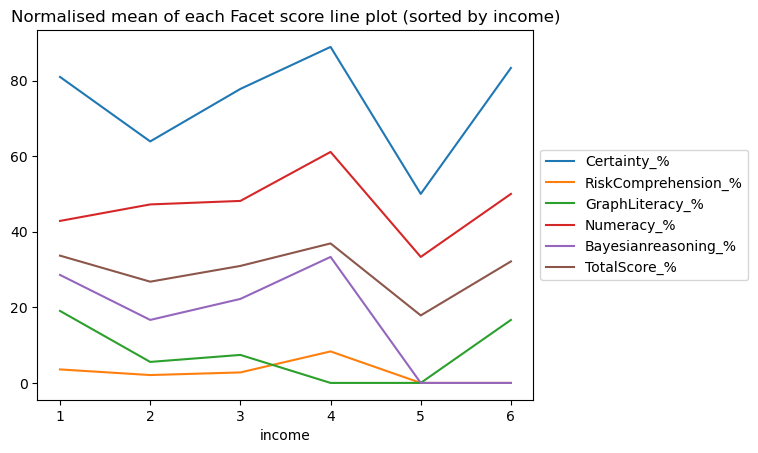

In [71]:
# Normalised mean of each Facet score line plot (sorted by income)


df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%', 'TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised mean of each Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

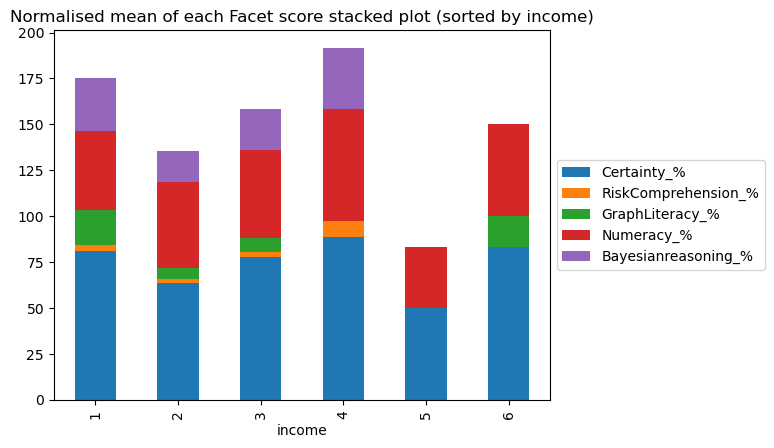

In [72]:
# Normalised mean of each Facet score stacked plot (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean of each Facet score stacked plot (sorted by income)', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

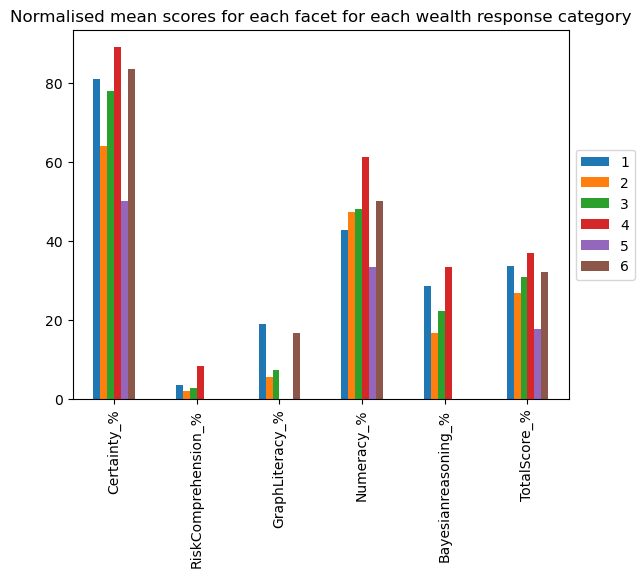

In [73]:
# Normalised mean of each Facet score hist plot (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='income', ylabel='TotalScore_14'>

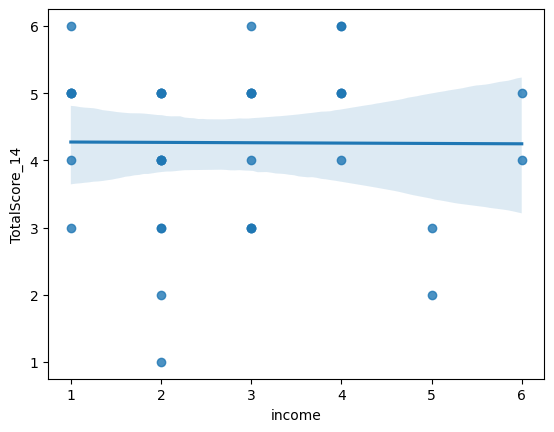

In [74]:
# Trend line for Absolute Total Facet Score vs income

sns.regplot (data = df3, x = 'income', y = 'TotalScore_14')

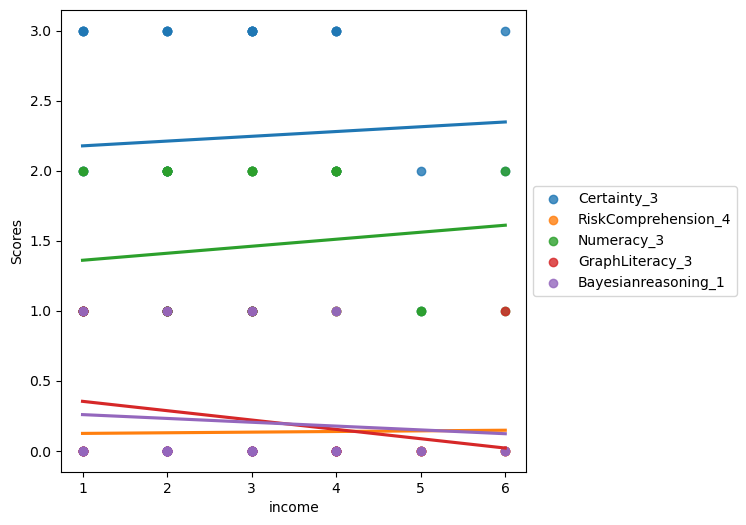

In [75]:
# Trend line for Absolute Independent Facet Score vs income reponses

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot (data = df3, x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax, label='Certainty_3')
sns.regplot (data = df3, x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax, label='RiskComprehension_4')
sns.regplot (data = df3, x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax, label='Numeracy_3')
sns.regplot (data = df3, x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax, label='GraphLiteracy_3')
sns.regplot (data = df3, x = 'income', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax, label='Bayesianreasoning_1' )

ax.set(ylabel='Scores', xlabel='income')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='income', ylabel='TotalScore_14'>

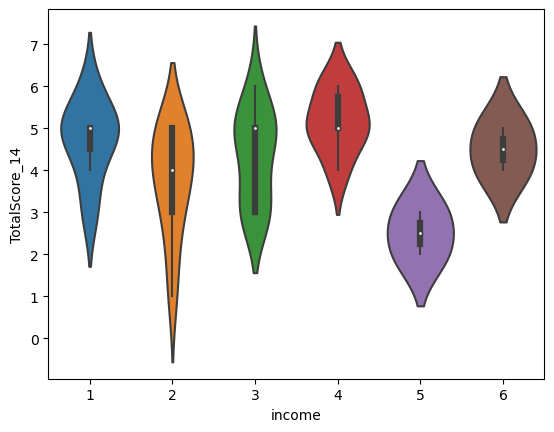

In [76]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'TotalScore_14')

<Axes: xlabel='income', ylabel='Certainty_3'>

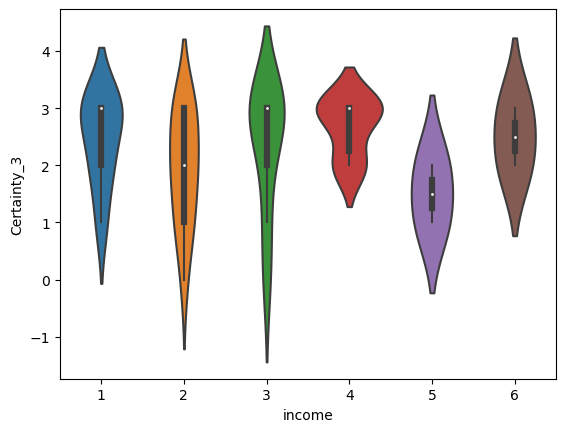

In [77]:
# Violine Plot for Certainty_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Certainty_3')

<Axes: xlabel='income', ylabel='RiskComprehension_4'>

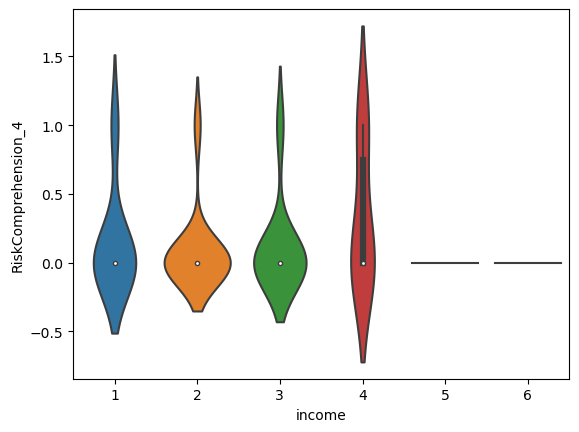

In [78]:
# Violine Plot for RiskComprehension_4 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'RiskComprehension_4')

<Axes: xlabel='income', ylabel='GraphLiteracy_3'>

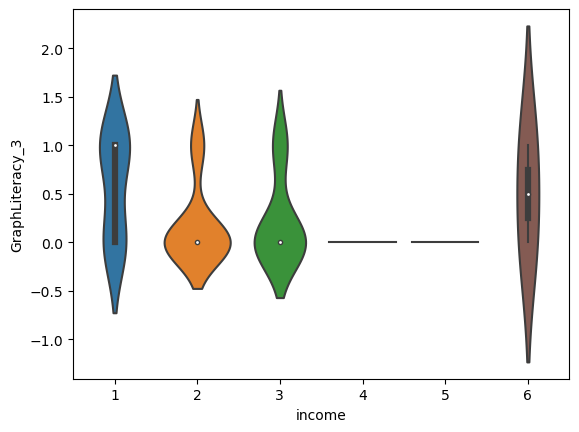

In [79]:
# Violine Plot for GraphLiteracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'GraphLiteracy_3')

<Axes: xlabel='income', ylabel='Numeracy_3'>

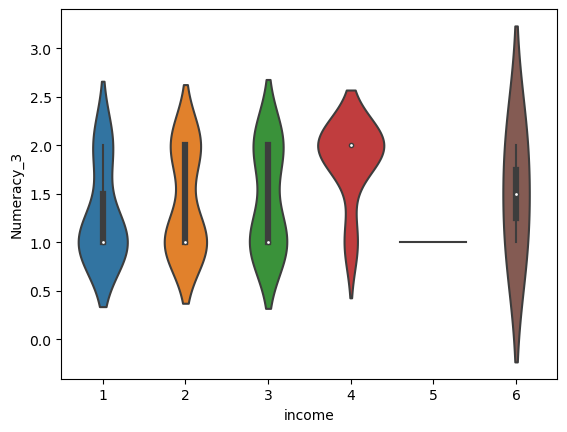

In [80]:
# Violine Plot for Numeracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Numeracy_3')

<Axes: xlabel='income', ylabel='Bayesianreasoning_1'>

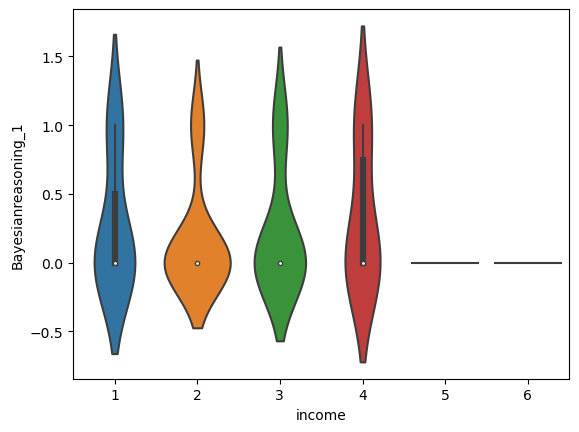

In [81]:
# Violine Plot for TotalScore_14 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Bayesianreasoning_1')

In [90]:
# Data Frame 2 or df2 is an aggregate data on facet total scores and over all total score, along with wealth and income data vs each response. 
# This data set is also sorted by wealth with all responses 'NA' removed.
# We also assign quartiles ranking each response according to this sort.

df4 = df2.sort_values(by = 'wealth')
df4 = df4.reset_index(drop = True)
df4 = df4.dropna(axis = 0, subset = 'wealth')
df4.insert(loc = len(df4.columns), column = "Quartile Number", value = pd.qcut(df4["wealth"].astype(int),q = 4, labels = False ) + 1, allow_duplicates = 'False')

df4

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0   R_9OjW44KK2eoxYq6   25        2      1       3         0            0   
1   R_4rqHwH5DM0AMTLj   29        2      1       3         1            3   
2   R_4fklajzbcuU4NST   29        2      1       2       100            3   
3   R_4lEUpdznwWtpRu1   57        4      1       3    100000            1   
4   R_4gbu4eNareZsG1n   51        3      1       2    100000            3   
5   R_4hmcVnKZPIvDOa7   42        3      1       4   1000000            2   
6   R_9DO5s0JxPsoShVq   65        4      2       2   1000000            0   
7   R_4L6m1FU0Ujmh3V7   19        2      3       2   1000000            1   
8   R_2jiyT9teVIVHpQy   25        2      2       3  10000000            3   
9   R_97I7fCImWYfF0c1   37        3      1       4  10000000            3   
10  R_93k9HjrDvW0Xd4d   42        3      2       3  10000000            3   
11  R_4Dvu7ZttFgPENwR   63        4      1       1   1100000            3   
12  R_9vdhG8DvdLvRPJ3   30        2      1       6  12500000            3   
13  R_9KkHAUQVKsGiBhe   26        2      2       3   1500000            3   
14  R_4ziRnglDZQo2B0t   40        3      2       2   1800000            3   
15  R_4lz68e8z2NuRRnB   65        4      1       1      2000            3   
16  R_9WK1oFSxYtmb82d   26        2      1       2   2000000            1   
17  R_4AY9PEqIAgaYkuZ   31        2      1       5  20000000            1   
18  R_4176twZZuUqgV9m   35        2      3       6  20500000            2   
19  R_4efA0IivV0kgbW4   43        3      2       1   2200000            3   
20  R_9s10NPIoxiHRAkx   21        2      3       1     30000            2   
21  R_94RdOE5ZgRNG4EN   34        2      1       2    300000            2   
22  R_3QLPNhaVQBnJsSe   45        3      1       3  34000000            3   
23  R_4ILQ6jRhbVna8kN   31        2      1       3  35000000            3   
24  R_40GWAL4WdQi5VAS   44        3      1       4  40000000            3   
25  R_4GJIH6GbqzLPmEv   50        3      2       1        50            1   
26  R_9OVVcpK6sOQlOIS   29        2      1       2    500000            3   
27  R_4McIMWBwCH9AFnv   21        2      1       2    500000            2   
28  R_4CyH4vrwFkIMDVD   31        2      2       2    500000            1   
29  R_4lhh2fUgLjRDBoW   37        3      1       4    500000            3   
30  R_9pbaa1ht3gisbyT   47        3      2       1   5000000            2   
31  R_93a68YKbkrwr9yI   62        4      2       1   5000000            3   
32  R_9CE2lLvpyPaeyKL   30        2      1       2   5000000            2   
33  R_2dh1JGHNy9Qf3Sc   27        2      1       5    560000            2   
34  R_4FsteJ71URQ4F4U   34        2      1       4   7000000            2   
35  R_37jpqSSD0cmMBQQ   65        4      2       2   7500000            2   
36  R_4IaSxXGv1CohFKJ   32        2      2       3   8000000            2   
37  R_4iP9ZyO9BmRTMnR   53        3      1       4   9000000            3   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                     1                0           2                    0   
1                     0                0           2                    0   
2                     0                0           1                    1   
3                     0                1           1                    0   
4                     0                0           1                    0   
5                     1                0           1                    1   
6                     0                0           1                    0   
7                     0                0           1                    0   
8                     0                0           2                    0   
9                     0                0           2                    1   
10                    0                0           1                    0   
11                    0                1           1                    0   
12    

<Axes: title={'center': 'Absolute mean score for each facet (Sort by Wealth)'}>

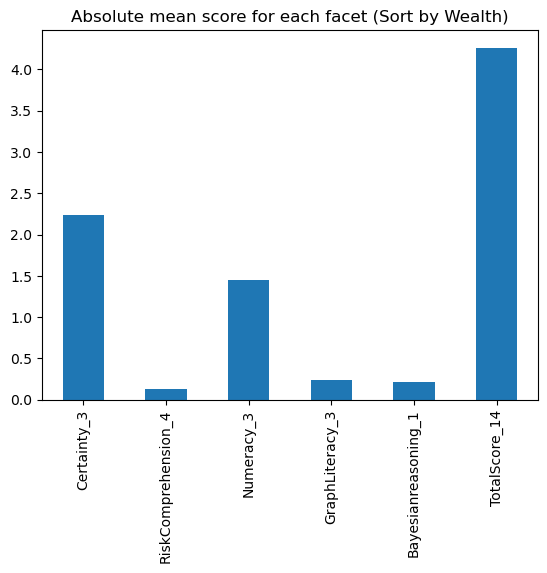

In [91]:
# Absolute mean score for each facet (Sort by Wealth)

df4[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1','TotalScore_14']].mean(axis = 0).plot(kind = 'bar', title = 'Absolute mean score for each facet (Sort by Wealth)')

<Axes: title={'center': 'Normalised mean score for each facet (Sort by Wealth)'}>

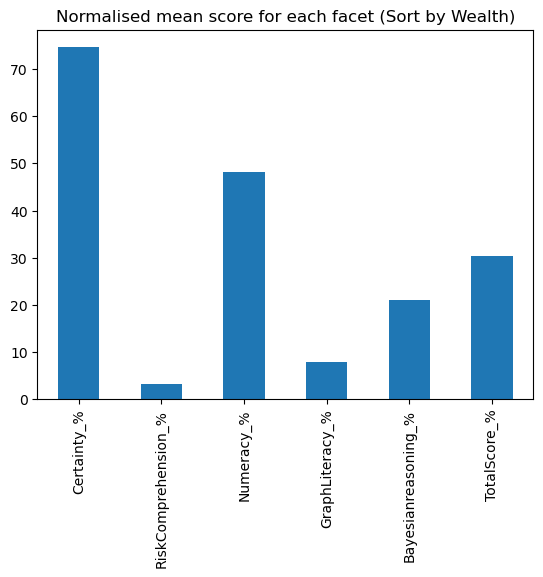

In [92]:
# Normalised mean score for each facet (Sort by Wealth)

(df4[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0)).plot(kind = 'bar', title = 'Normalised mean score for each facet (Sort by Wealth)')

<Axes: title={'center': 'Total responses line plot sorted by Wealth'}, xlabel='Unique responses sorted by wealth', ylabel='TotalScore_14'>

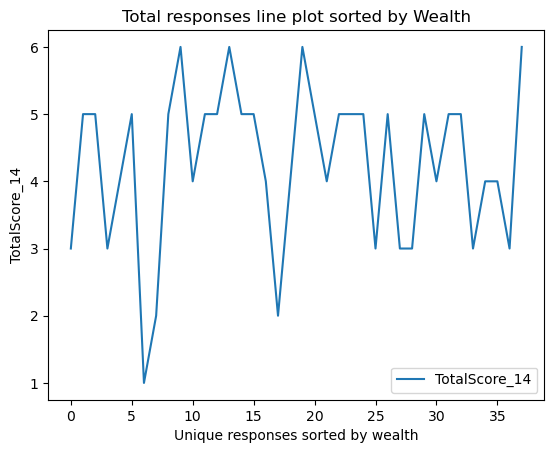

In [93]:
# Line Plot of Absolute Total Facet score vs sorted wealth

df4.plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total responses line plot sorted by Wealth',xlabel = 'Unique responses sorted by wealth', ylabel = 'TotalScore_14')

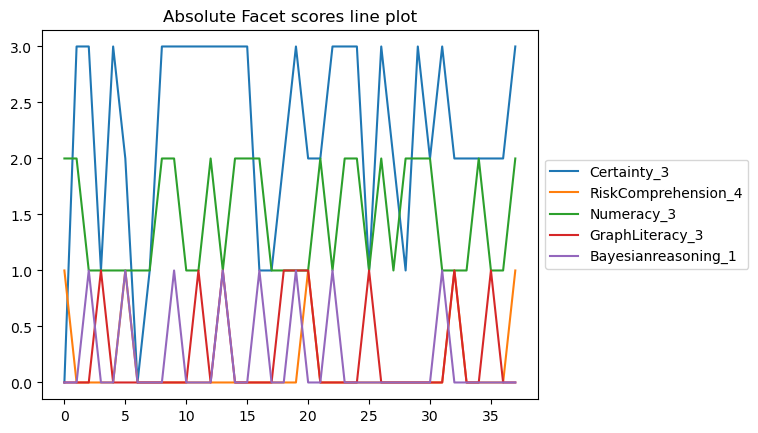

In [94]:
# Absolute Facet scores line plot from low to high wealth 
# I do understand that this is non readable

df4[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].plot( kind = 'line', title = 'Absolute Facet scores line plot', use_index = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: ylabel='TotalScore_14'>

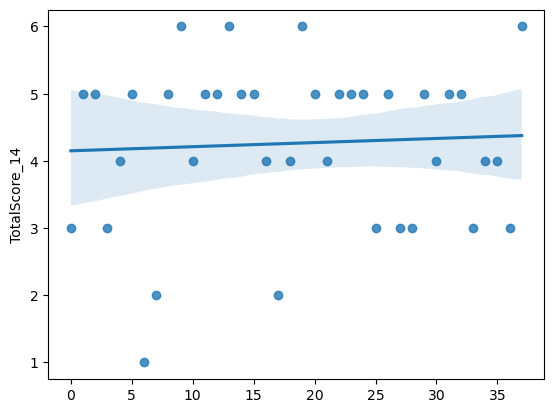

In [95]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses

sns.regplot (data = df4, x = df4.index, y = 'TotalScore_14')

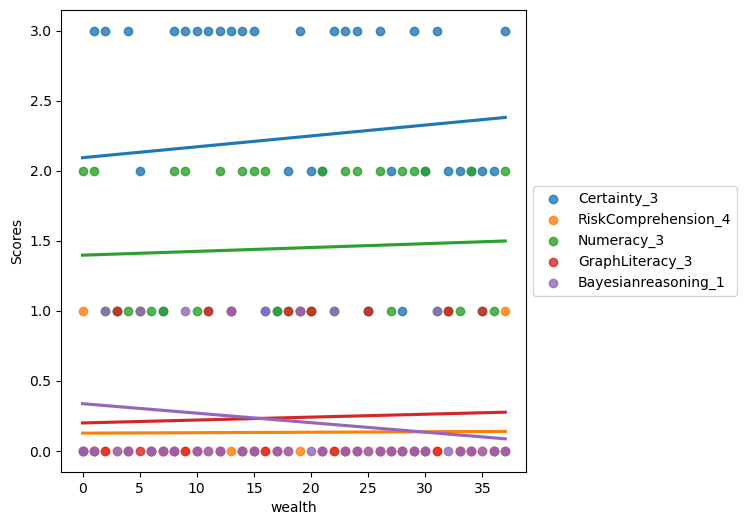

In [96]:
# Trend line for Absolute Independent Facet Score vs wealth reponses

fig1, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = df4.index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax1, label='Certainty_3')
sns.regplot (data = df4, x = df4.index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax1, label='RiskComprehension_4')
sns.regplot (data = df4, x = df4.index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax1, label='Numeracy_3')
sns.regplot (data = df4, x = df4.index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax1, label='GraphLiteracy_3')
sns.regplot (data = df4, x = df4.index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax1, label='Bayesianreasoning_1' )

ax1.set(ylabel='Scores', xlabel='wealth')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [97]:
# Count of number of responses under each quartile

df4.groupby('Quartile Number')[['Quartile Number']].count()

Quartile Number
Quartile Number                 
1                             13
2                              6
3                              9
4                             10

In [98]:
df4.loc[df4['Quartile Number']==1]

ResponseId  age  age_rec  isced  income  wealth  Certainty_3  \
0   R_9OjW44KK2eoxYq6   25        2      1       3       0            0   
1   R_4rqHwH5DM0AMTLj   29        2      1       3       1            3   
2   R_4fklajzbcuU4NST   29        2      1       2     100            3   
3   R_4lEUpdznwWtpRu1   57        4      1       3  100000            1   
4   R_4gbu4eNareZsG1n   51        3      1       2  100000            3   
15  R_4lz68e8z2NuRRnB   65        4      1       1    2000            3   
20  R_9s10NPIoxiHRAkx   21        2      3       1   30000            2   
21  R_94RdOE5ZgRNG4EN   34        2      1       2  300000            2   
25  R_4GJIH6GbqzLPmEv   50        3      2       1      50            1   
26  R_9OVVcpK6sOQlOIS   29        2      1       2  500000            3   
27  R_4McIMWBwCH9AFnv   21        2      1       2  500000            2   
28  R_4CyH4vrwFkIMDVD   31        2      2       2  500000            1   
29  R_4lhh2fUgLjRDBoW   37        3      1       4  500000            3   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                     1                0           2                    0   
1                     0                0           2                    0   
2                     0                0           1                    1   
3                     0                1           1                    0   
4                     0                0           1                    0   
15                    0                0           2                    0   
20                    1                1           1                    0   
21                    0                0           2                    0   
25                    0                1           1                    0   
26                    0                0           2                    0   
27                    0                0           1                    0   
28                    0                0           2                    0   
29                    0                0           2                    0   

    Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0      0.000000                 25.0         0.000000   66.666667   
1    100.000000                  0.0         0.000000   66.666667   
2    100.000000                  0.0         0.000000   33.333333   
3     33.333333                  0.0        33.333333   33.333333   
4    100.000000                  0.0         0.000000   33.333333   
15   100.000000                  0.0         0.000000   66.666667   
20    66.666667                 25.0        33.333333   33.333333   
21    66.666667                  0.0         0.000000   66.666667   
25    33.333333                  0.0        33.333333   33.333333   
26   100.000000                  0.0         0.000000   66.666667   
27    66.666667                  0.0         0.000000   33.333333   
28    33.333333                  0.0         0.000000   66.666667   
29   100.000000                  0.0         0.000000   66.666667   

    Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
0                   0.0              3     21.428571                1  
1                   0.0              5     35.714286                1  
2                 100.0              5     35.714286                1  
3                   0.0              3     21.428571                1  
4                   0.0              4     28.571429                1  
15                  0.0              5     35.714286                1  
20                  0.0              5     35.714286                1  
21                  0.0              4     28.571429                1  
25                  0.0              3     21.428571                1  
26                  0.0              5     35.714286                1  
27                  0.0              3     21.428571                1  
28                  0.0              3     21.4285

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q1'}, xlabel='Unique responses', ylabel='TotalScore_14'>

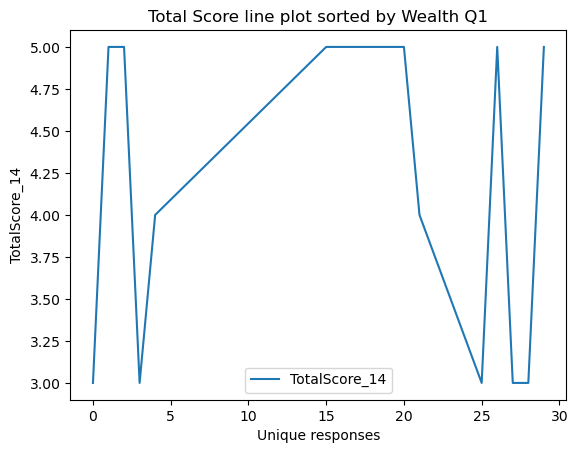

In [99]:
# This graph is basically a line plot of the TotalScore_14 across first quartile unique responses which are ordered by income

df4.loc[df4['Quartile Number']==1].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q1',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

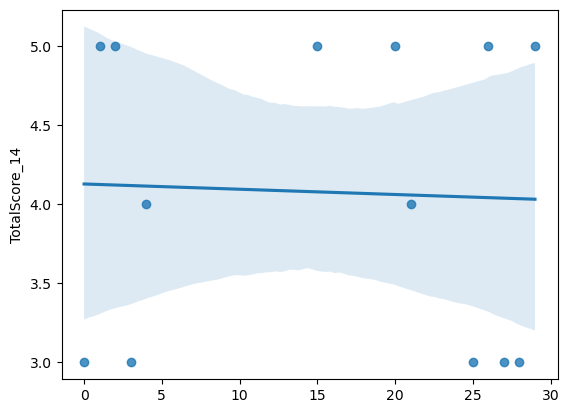

In [100]:
# Trend line for Absolute Total Facet Score vs unique Q14. Income reponses in Quartile 1

sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'TotalScore_14')

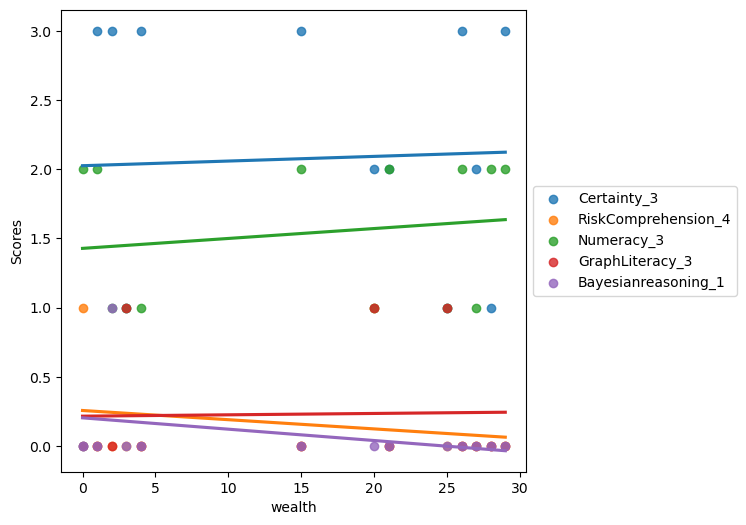

In [101]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 1

fig1, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax2, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==1], x = df4.loc[df4['Quartile Number']==1].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [102]:
df4.loc[df4['Quartile Number']==2]

ResponseId  age  age_rec  isced  income   wealth  Certainty_3  \
5   R_4hmcVnKZPIvDOa7   42        3      1       4  1000000            2   
6   R_9DO5s0JxPsoShVq   65        4      2       2  1000000            0   
7   R_4L6m1FU0Ujmh3V7   19        2      3       2  1000000            1   
11  R_4Dvu7ZttFgPENwR   63        4      1       1  1100000            3   
13  R_9KkHAUQVKsGiBhe   26        2      2       3  1500000            3   
33  R_2dh1JGHNy9Qf3Sc   27        2      1       5   560000            2   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
5                     1                0           1                    1   
6                     0                0           1                    0   
7                     0                0           1                    0   
11                    0                1           1                    0   
13                    0                1           1                    1   
33                    0                0           1                    0   

    Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
5     66.666667                 25.0         0.000000   33.333333   
6      0.000000                  0.0         0.000000   33.333333   
7     33.333333                  0.0         0.000000   33.333333   
11   100.000000                  0.0        33.333333   33.333333   
13   100.000000                  0.0        33.333333   33.333333   
33    66.666667                  0.0         0.000000   33.333333   

    Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
5                 100.0              5     35.714286                2  
6                   0.0              1      7.142857                2  
7                   0.0              2     14.285714                2  
11                  0.0              5     35.714286                2  
13                100.0              6     42.857143                2  
33                  0.0              3     21.428571                2

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q1'}, xlabel='Unique responses', ylabel='TotalScore_14'>

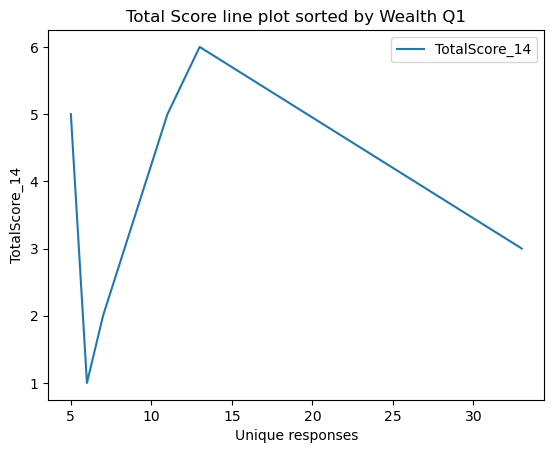

In [103]:
# This graph is basically a line plot of the TotalScore_14 across second quartile unique responses which are ordered by income

df4.loc[df4['Quartile Number']==2].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q1',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

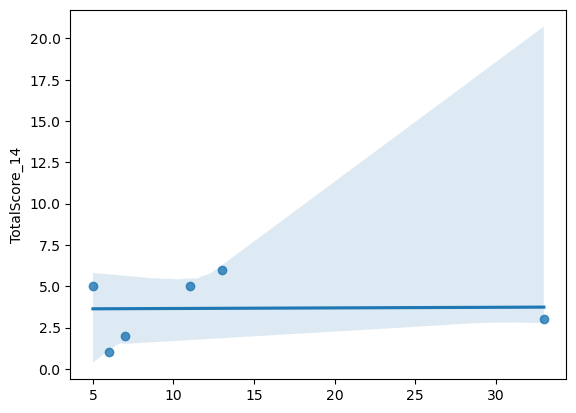

In [104]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 2

sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'TotalScore_14')

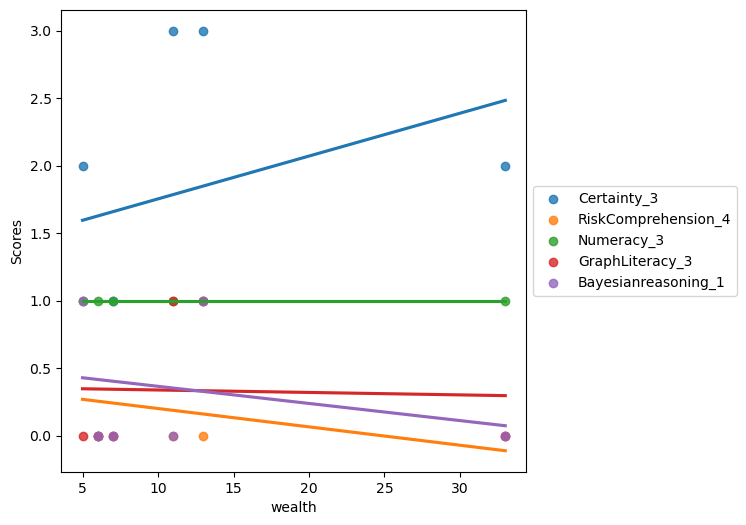

In [105]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 2

fig1, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax3, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax3, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax3, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax3, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==2], x = df4.loc[df4['Quartile Number']==2].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax3, label='Bayesianreasoning_1' )

ax3.set(ylabel='Scores', xlabel='wealth')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [106]:
df4.loc[df4['Quartile Number']==3]

ResponseId  age  age_rec  isced  income   wealth  Certainty_3  \
14  R_4ziRnglDZQo2B0t   40        3      2       2  1800000            3   
16  R_9WK1oFSxYtmb82d   26        2      1       2  2000000            1   
19  R_4efA0IivV0kgbW4   43        3      2       1  2200000            3   
30  R_9pbaa1ht3gisbyT   47        3      2       1  5000000            2   
31  R_93a68YKbkrwr9yI   62        4      2       1  5000000            3   
32  R_9CE2lLvpyPaeyKL   30        2      1       2  5000000            2   
34  R_4FsteJ71URQ4F4U   34        2      1       4  7000000            2   
35  R_37jpqSSD0cmMBQQ   65        4      2       2  7500000            2   
36  R_4IaSxXGv1CohFKJ   32        2      2       3  8000000            2   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
14                    0                0           2                    0   
16                    0                0           2                    1   
19                    0                1           1                    1   
30                    0                0           2                    0   
31                    0                0           1                    1   
32                    1                1           1                    0   
34                    0                0           2                    0   
35                    0                1           1                    0   
36                    0                0           1                    0   

    Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
14   100.000000                  0.0         0.000000   66.666667   
16    33.333333                  0.0         0.000000   66.666667   
19   100.000000                  0.0        33.333333   33.333333   
30    66.666667                  0.0         0.000000   66.666667   
31   100.000000                  0.0         0.000000   33.333333   
32    66.666667                 25.0        33.333333   33.333333   
34    66.666667                  0.0         0.000000   66.666667   
35    66.666667                  0.0        33.333333   33.333333   
36    66.666667                  0.0         0.000000   33.333333   

    Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
14                  0.0              5     35.714286                3  
16                100.0              4     28.571429                3  
19                100.0              6     42.857143                3  
30                  0.0              4     28.571429                3  
31                100.0              5     35.714286                3  
32                  0.0              5     35.714286                3  
34                  0.0              4     28.571429                3  
35                  0.0              4     28.571429                3  
36                  0.0              3     21.428571                3

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q3'}, xlabel='Unique responses', ylabel='TotalScore_14'>

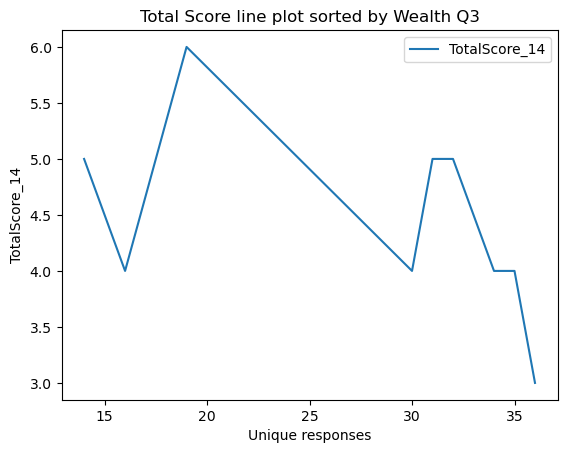

In [107]:
# This graph is basically a line plot of the TotalScore_14 across third quartile unique responses which are ordered by wealth

df4.loc[df4['Quartile Number']==3].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q3',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

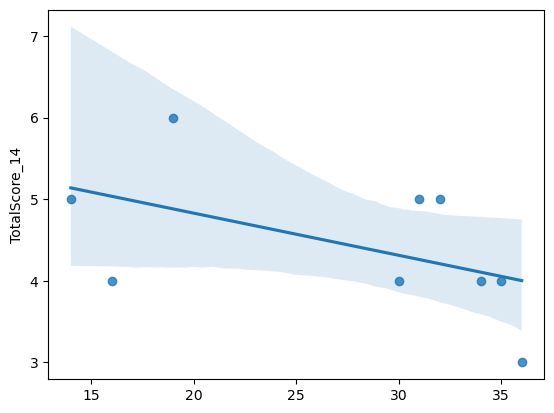

In [108]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 3

sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'TotalScore_14')

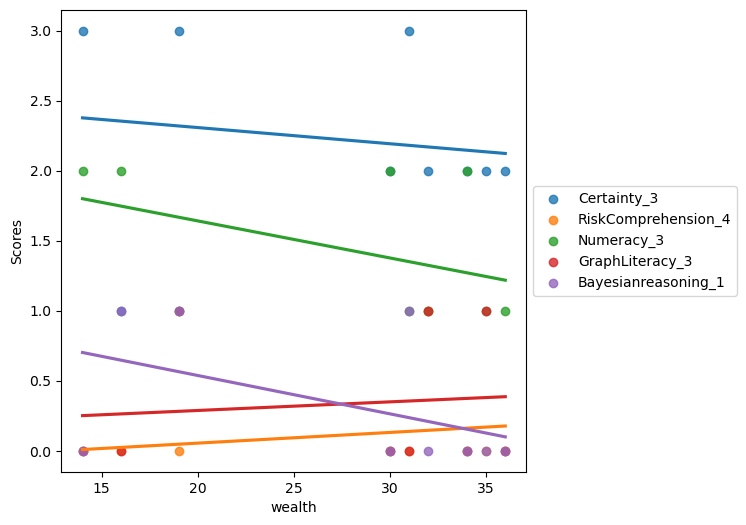

In [109]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 3

fig1, ax4 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax4, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax4, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax4, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax4, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==3], x = df4.loc[df4['Quartile Number']==3].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax4, label='Bayesianreasoning_1' )

ax4.set(ylabel='Scores', xlabel='wealth')
ax4.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [110]:
df4.loc[df4['Quartile Number']==4]

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
8   R_2jiyT9teVIVHpQy   25        2      2       3  10000000            3   
9   R_97I7fCImWYfF0c1   37        3      1       4  10000000            3   
10  R_93k9HjrDvW0Xd4d   42        3      2       3  10000000            3   
12  R_9vdhG8DvdLvRPJ3   30        2      1       6  12500000            3   
17  R_4AY9PEqIAgaYkuZ   31        2      1       5  20000000            1   
18  R_4176twZZuUqgV9m   35        2      3       6  20500000            2   
22  R_3QLPNhaVQBnJsSe   45        3      1       3  34000000            3   
23  R_4ILQ6jRhbVna8kN   31        2      1       3  35000000            3   
24  R_40GWAL4WdQi5VAS   44        3      1       4  40000000            3   
37  R_4iP9ZyO9BmRTMnR   53        3      1       4   9000000            3   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
8                     0                0           2                    0   
9                     0                0           2                    1   
10                    0                0           1                    0   
12                    0                0           2                    0   
17                    0                0           1                    0   
18                    0                1           1                    0   
22                    0                0           1                    1   
23                    0                0           2                    0   
24                    0                0           2                    0   
37                    1                0           2                    0   

    Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
8    100.000000                  0.0         0.000000   66.666667   
9    100.000000                  0.0         0.000000   66.666667   
10   100.000000                  0.0         0.000000   33.333333   
12   100.000000                  0.0         0.000000   66.666667   
17    33.333333                  0.0         0.000000   33.333333   
18    66.666667                  0.0        33.333333   33.333333   
22   100.000000                  0.0         0.000000   33.333333   
23   100.000000                  0.0         0.000000   66.666667   
24   100.000000                  0.0         0.000000   66.666667   
37   100.000000                 25.0         0.000000   66.666667   

    Bayesianreasoning_%  TotalScore_14  TotalScore_%  Quartile Number  
8                   0.0              5     35.714286                4  
9                 100.0              6     42.857143                4  
10                  0.0              4     28.571429                4  
12                  0.0              5     35.714286                4  
17                  0.0              2     14.285714                4  
18                  0.0              4     28.571429                4  
22                100.0              5     35.714286                4  
23                  0.0              5     35.714286                4  
24                  0.0              5     35.714286                4  
37                  0.0              6     42.857143                4

<Axes: title={'center': 'Total Score line plot sorted by Wealth Q4'}, xlabel='Unique responses', ylabel='TotalScore_14'>

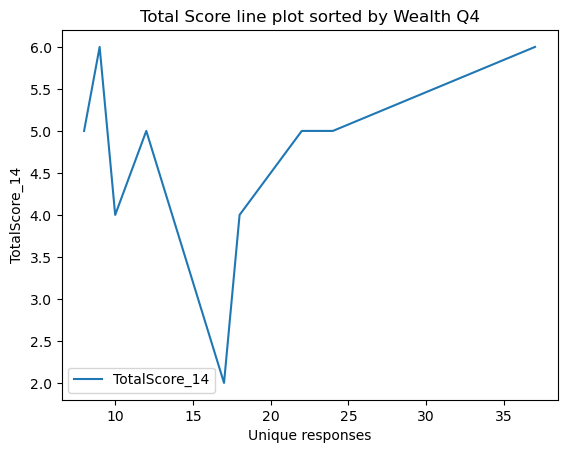

In [111]:
# This graph is basically a line plot of the TotalScore_14 across fourth quartile unique responses which are ordered by Wealth

df4.loc[df4['Quartile Number']==4].plot(use_index = 'True' , kind = 'line', y = ['TotalScore_14'], title = 'Total Score line plot sorted by Wealth Q4',xlabel = 'Unique responses', ylabel = 'TotalScore_14')

<Axes: ylabel='TotalScore_14'>

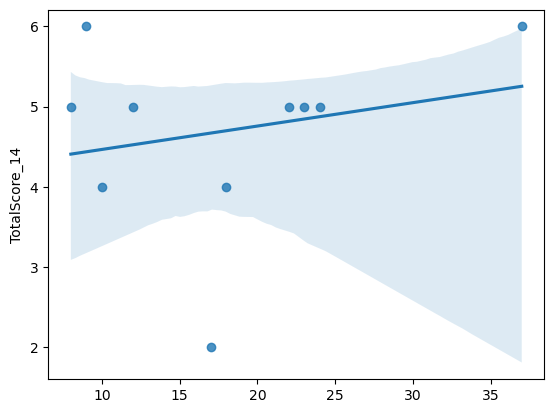

In [112]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses in Quartile 4

sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'TotalScore_14')

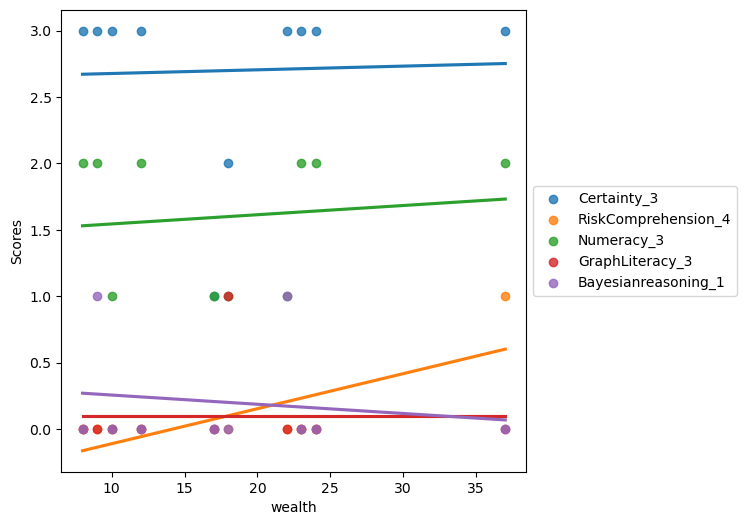

In [113]:
# Trend line for Absolute Independent Facet Score vs wealth reponses in Quartile 4

fig1, ax5 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Certainty_3', fit_reg=True, ci=None, ax=ax5, label='Certainty_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax5, label='RiskComprehension_4')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax5, label='Numeracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax5, label='GraphLiteracy_3')
sns.regplot (data = df4.loc[df4['Quartile Number']==4], x = df4.loc[df4['Quartile Number']==4].index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax5, label='Bayesianreasoning_1' )

ax5.set(ylabel='Scores', xlabel='wealth')
ax5.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

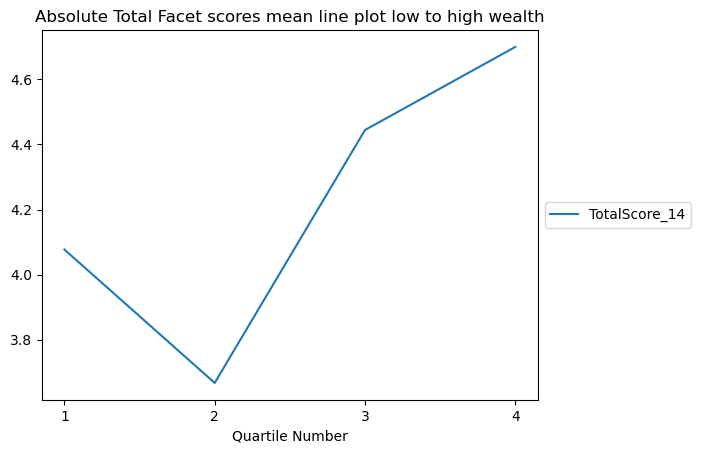

In [114]:
# Absolute Total Facet scores mean line plot from low to high Wealth

df4.groupby('Quartile Number')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

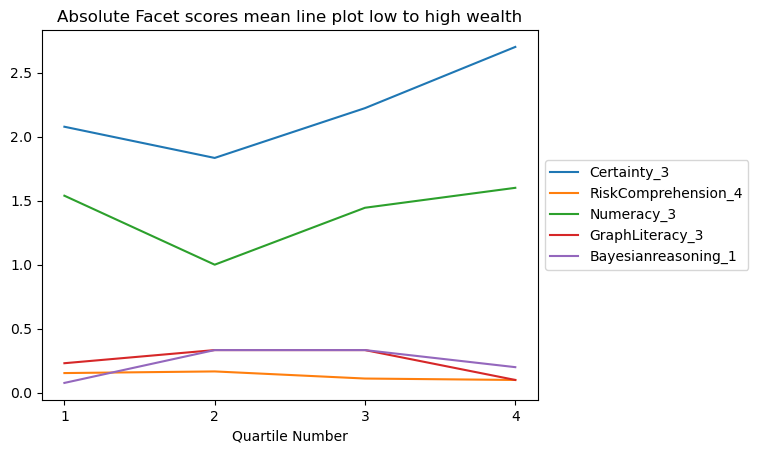

In [115]:
# Absolute Facet scores mean line plot from low to high wealth

df4.groupby('Quartile Number')[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

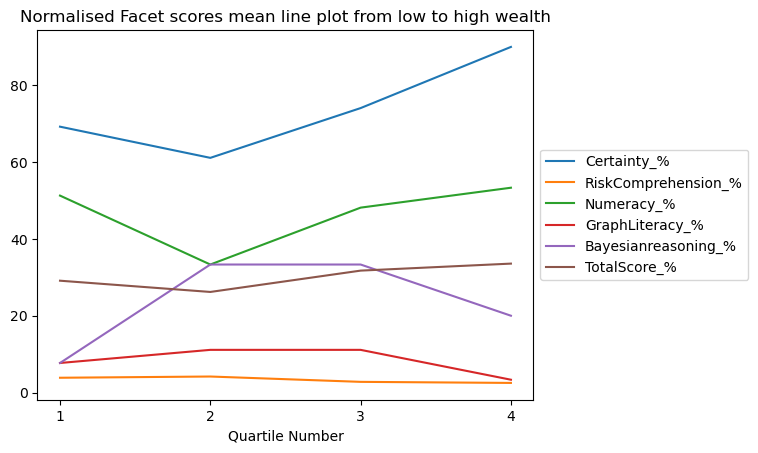

In [116]:
# Normalised Facet scores mean line plot from low to high wealth


df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot from low to high wealth',  xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

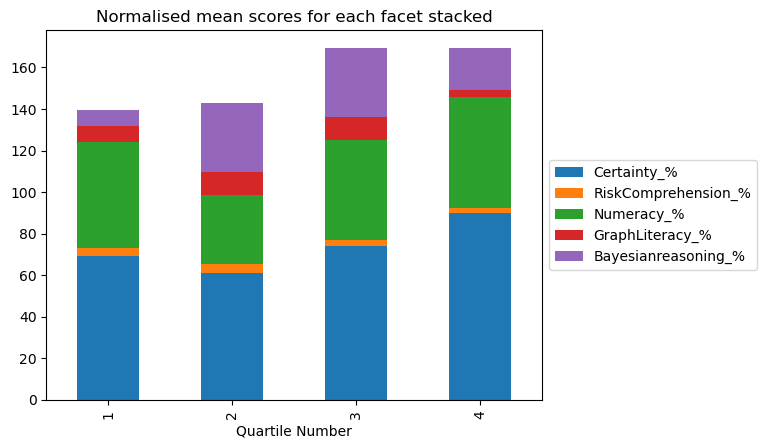

In [117]:
# Normalised mean scores for each facet stacked

df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

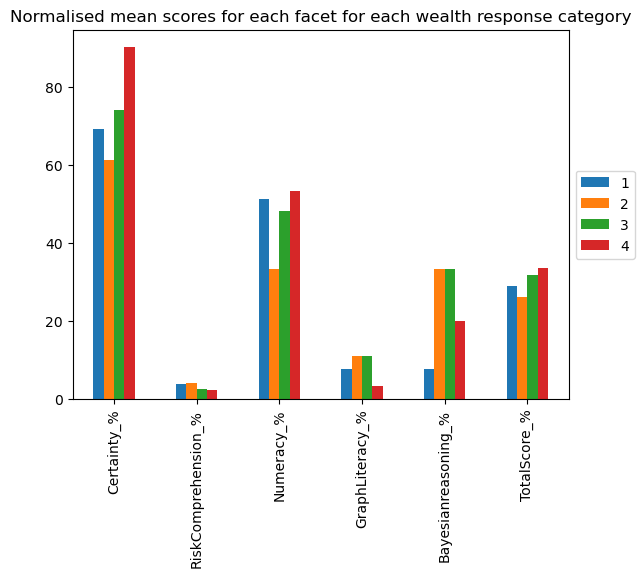

In [118]:
# Normalised mean scores for each facet for each wealth response Quartile

df4.groupby('Quartile Number')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

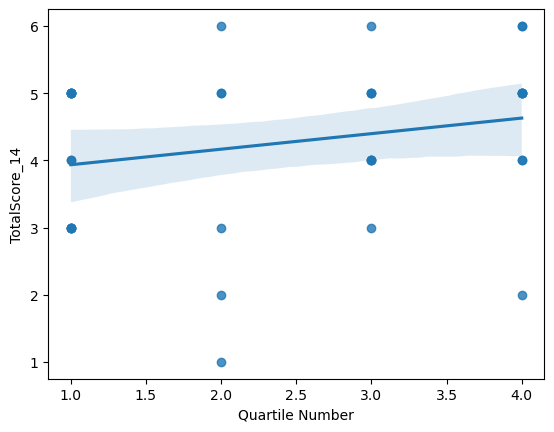

In [119]:
# Trend line for Absolute Total Facet Score vs Quartiles

sns.regplot (data = df4, x = 'Quartile Number', y = 'TotalScore_14')

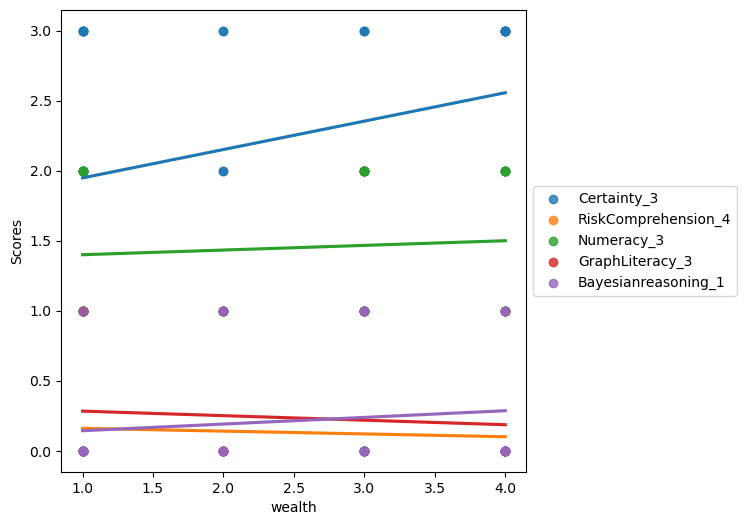

In [120]:
# Trend line for Absolute Independent Facet Score vs Quartiles

fig2, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = 'Quartile Number', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax2, label='Certainty_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_4')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax2, label='Numeracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='Quartile Number', ylabel='TotalScore_14'>

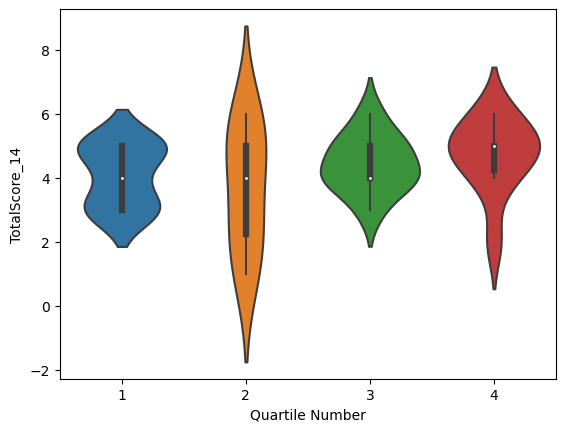

In [121]:
# Violine Plot for TotalScore_14 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'TotalScore_14')

<Axes: xlabel='Quartile Number', ylabel='Certainty_3'>

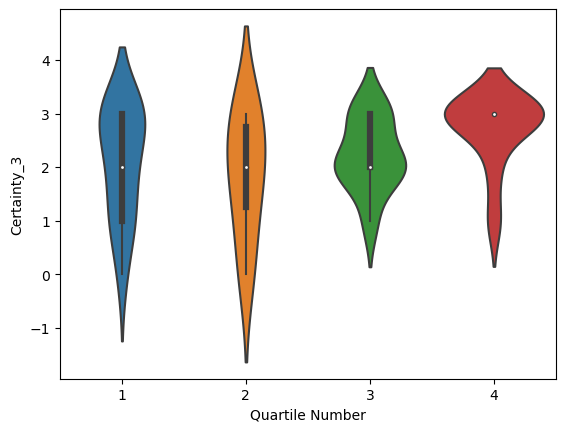

In [122]:
# Violine Plot for Certainty_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Certainty_3')

<Axes: xlabel='Quartile Number', ylabel='RiskComprehension_4'>

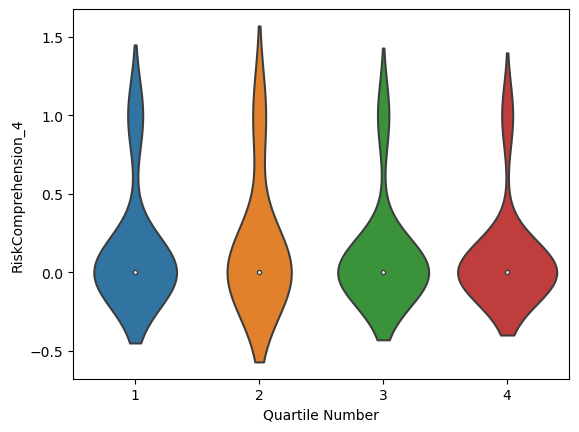

In [123]:
# Violine Plot for RiskComprehension_4 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'RiskComprehension_4')

<Axes: xlabel='Quartile Number', ylabel='GraphLiteracy_3'>

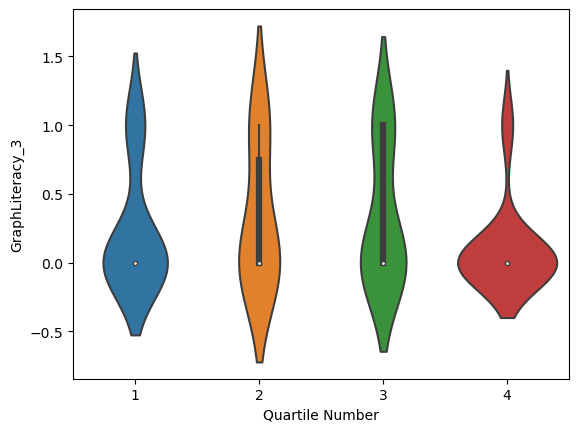

In [124]:
# Violine Plot for GraphLiteracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3')

<Axes: xlabel='Quartile Number', ylabel='Numeracy_3'>

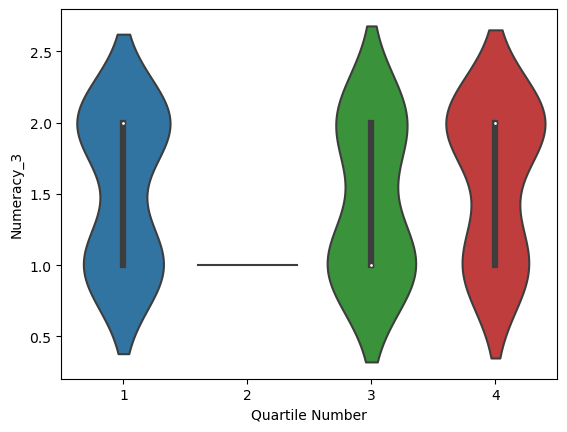

In [125]:
# Violine Plot for Numeracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Numeracy_3')

<Axes: xlabel='Quartile Number', ylabel='Bayesianreasoning_1'>

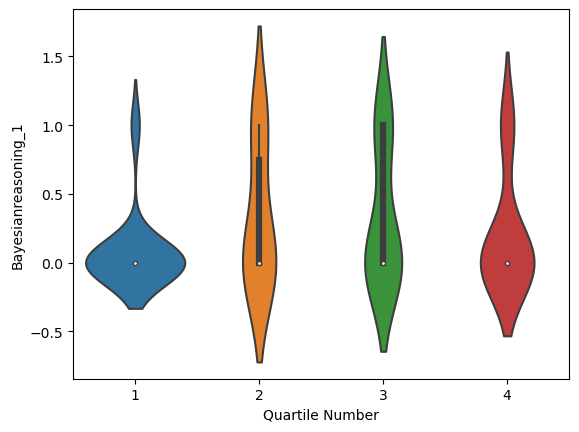

In [126]:
# Violine Plot for Bayesianreasoning_1 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1')

In [127]:
# Data Frame 5 or df5 is an aggregate data on facet total scores and over all total score, along with  education data vs each response. 
# This data set is now sorted by education.

df5 = df2.sort_values(by = 'isced')
df5 = df5.reset_index(drop = True)

df5

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0   R_2dh1JGHNy9Qf3Sc   27        2      1       5    560000            2   
1   R_9WK1oFSxYtmb82d   26        2      1       2   2000000            1   
2   R_9OjW44KK2eoxYq6   25        2      1       3         0            0   
3   R_9OVVcpK6sOQlOIS   29        2      1       2    500000            3   
4   R_9CE2lLvpyPaeyKL   30        2      1       2   5000000            2   
5   R_97I7fCImWYfF0c1   37        3      1       4  10000000            3   
6   R_94RdOE5ZgRNG4EN   34        2      1       2    300000            2   
7   R_4rqHwH5DM0AMTLj   29        2      1       3         1            3   
8   R_4lz68e8z2NuRRnB   65        4      1       1      2000            3   
9   R_4lhh2fUgLjRDBoW   37        3      1       4    500000            3   
10  R_4lEUpdznwWtpRu1   57        4      1       3    100000            1   
11  R_4iP9ZyO9BmRTMnR   53        3      1       4   9000000            3   
12  R_4gbu4eNareZsG1n   51        3      1       2    100000            3   
13  R_4fklajzbcuU4NST   29        2      1       2       100            3   
14  R_4hmcVnKZPIvDOa7   42        3      1       4   1000000            2   
15  R_9vdhG8DvdLvRPJ3   30        2      1       6  12500000            3   
16  R_4ILQ6jRhbVna8kN   31        2      1       3  35000000            3   
17  R_3QLPNhaVQBnJsSe   45        3      1       3  34000000            3   
18  R_4FsteJ71URQ4F4U   34        2      1       4   7000000            2   
19  R_4Dvu7ZttFgPENwR   63        4      1       1   1100000            3   
20  R_40GWAL4WdQi5VAS   44        3      1       4  40000000            3   
21  R_4McIMWBwCH9AFnv   21        2      1       2    500000            2   
22  R_4AY9PEqIAgaYkuZ   31        2      1       5  20000000            1   
23  R_9pbaa1ht3gisbyT   47        3      2       1   5000000            2   
24  R_2jiyT9teVIVHpQy   25        2      2       3  10000000            3   
25  R_37jpqSSD0cmMBQQ   65        4      2       2   7500000            2   
26  R_9KkHAUQVKsGiBhe   26        2      2       3   1500000            3   
27  R_9DO5s0JxPsoShVq   65        4      2       2   1000000            0   
28  R_4efA0IivV0kgbW4   43        3      2       1   2200000            3   
29  R_93a68YKbkrwr9yI   62        4      2       1   5000000            3   
30  R_4ziRnglDZQo2B0t   40        3      2       2   1800000            3   
31  R_4CyH4vrwFkIMDVD   31        2      2       2    500000            1   
32  R_4GJIH6GbqzLPmEv   50        3      2       1        50            1   
33  R_4IaSxXGv1CohFKJ   32        2      2       3   8000000            2   
34  R_93k9HjrDvW0Xd4d   42        3      2       3  10000000            3   
35  R_9s10NPIoxiHRAkx   21        2      3       1     30000            2   
36  R_4L6m1FU0Ujmh3V7   19        2      3       2   1000000            1   
37  R_4176twZZuUqgV9m   35        2      3       6  20500000            2   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                     0                0           1                    0   
1                     0                0           2                    1   
2                     1                0           2                    0   
3                     0                0           2                    0   
4                     1                1           1                    0   
5                     0                0           2                    1   
6                     0                0           2                    0   
7                     0                0           2                    0   
8                     0                0           2                    0   
9                     0                0           2                    0   
10                    0                1           1                    0   
11                    1                0           2                    0   
12    

In [128]:
# since we didnt drop any values, the dataset is essentially the same as df2, but sorted

In [129]:
# Mean of each facet as a % for each category of isced

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean()

Certainty_%  RiskComprehension_%  Numeracy_%  GraphLiteracy_%  \
isced                                                                  
1        78.260870             4.347826   52.173913         4.347826   
2        72.222222             0.000000   44.444444        11.111111   
3        55.555556             8.333333   33.333333        22.222222   

       Bayesianreasoning_%  
isced                       
1                 21.73913  
2                 25.00000  
3                  0.00000

In [130]:
# Count of responses for each category isced

df5.groupby('isced')[['ResponseId']].count()

ResponseId
isced            
1              23
2              12
3               3

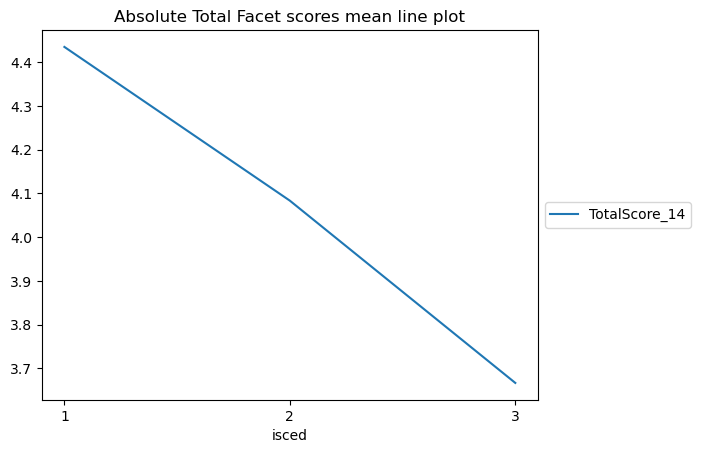

In [131]:
# Absolute Total Facet scores mean line plot from low to high education

df5.groupby('isced')[['TotalScore_14']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

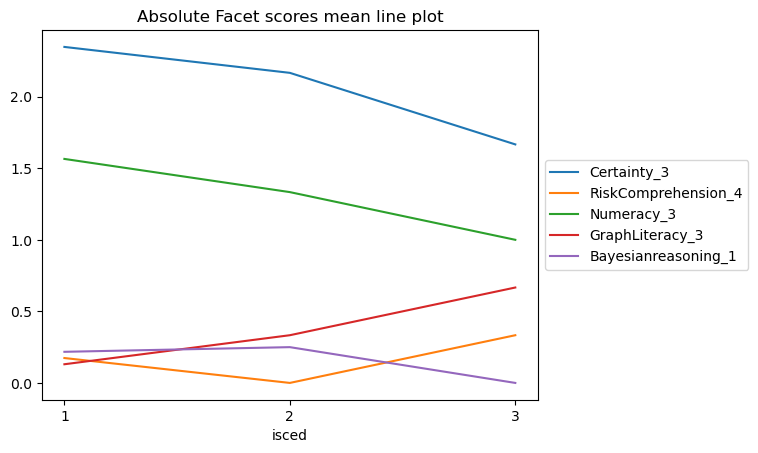

In [132]:
# Absolute Facet scores mean line plot from low to high edu

df5.groupby('isced')[['Certainty_3','RiskComprehension_4','Numeracy_3','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

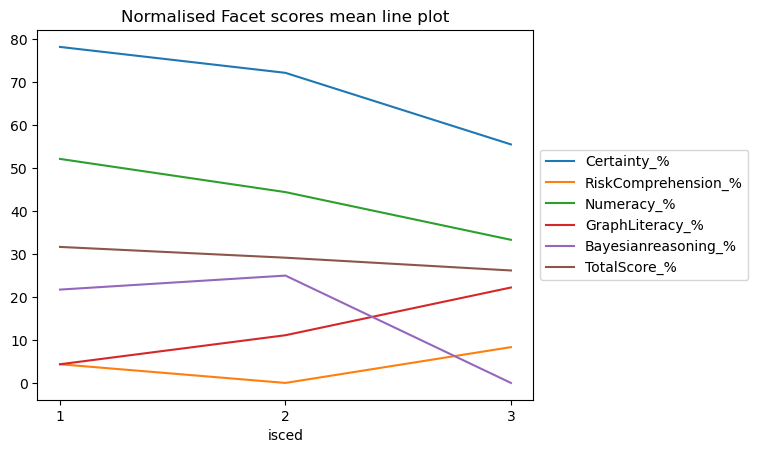

In [133]:
# Normalised Facet scores mean line plot from low to high edu


df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

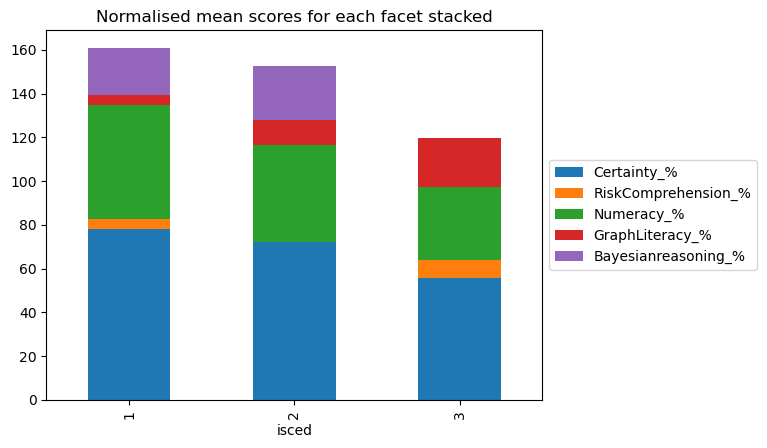

In [134]:
# Normalised mean scores for each facet stacked

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

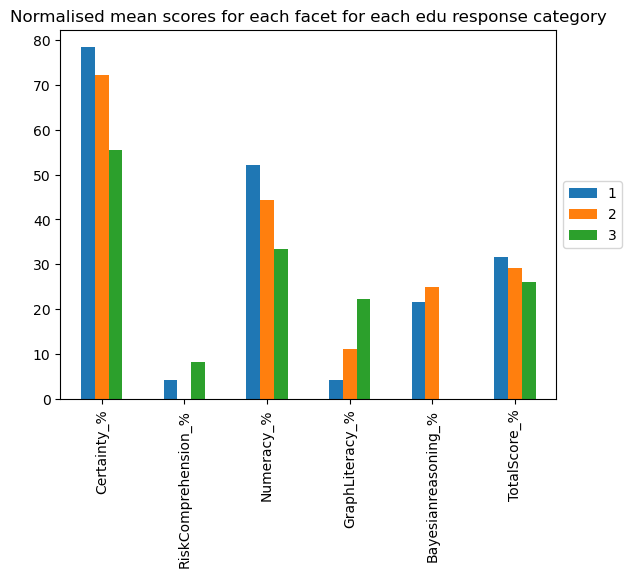

In [135]:
# Normalised mean scores for each facet for each edu response category

df5.groupby('isced')[['Certainty_%','RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each edu response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='isced', ylabel='TotalScore_14'>

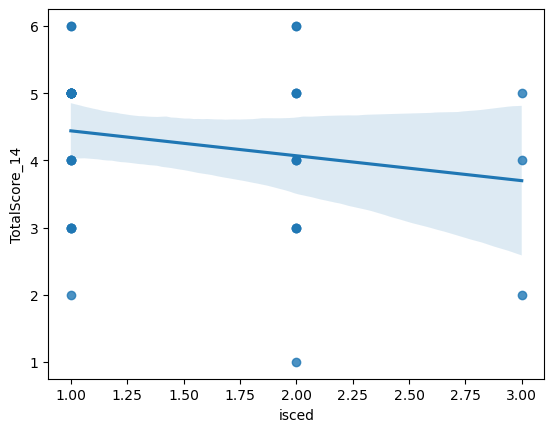

In [136]:
# Trend line for Absolute Total Facet Score vs edu (isced) reponses

sns.regplot (data = df5, x = 'isced', y = 'TotalScore_14')

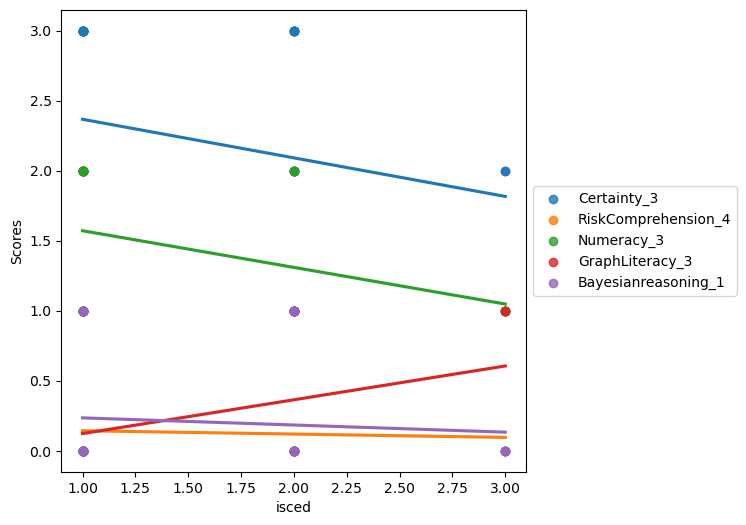

In [137]:
# Trend line for Absolute Independent Facet Score vs edu (isced) reponses

fig, ax6 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df5, x = 'isced', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax6, label='Certainty_3')
sns.regplot (data = df5, x = 'isced', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax6, label='RiskComprehension_4')
sns.regplot (data = df5, x = 'isced', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax6, label='Numeracy_3')
sns.regplot (data = df5, x = 'isced', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax6, label='GraphLiteracy_3')
sns.regplot (data = df5, x = 'isced', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax6, label='Bayesianreasoning_1' )

ax6.set(ylabel='Scores', xlabel='isced')
ax6.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='isced', ylabel='TotalScore_14'>

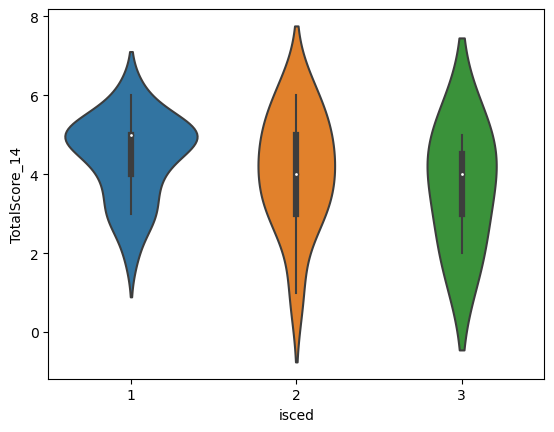

In [138]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'TotalScore_14')

<Axes: xlabel='isced', ylabel='Certainty_3'>

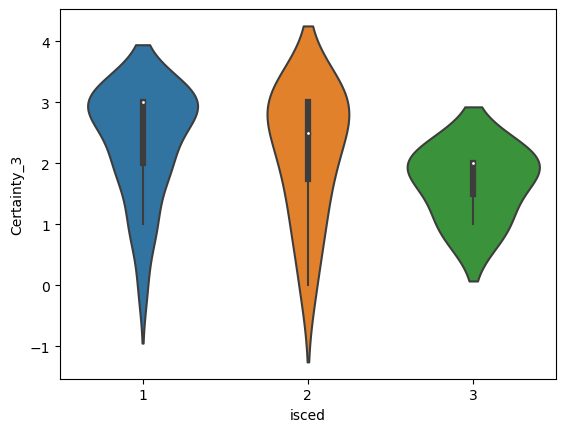

In [139]:
# Violine Plot for Certainty_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Certainty_3')

<Axes: xlabel='isced', ylabel='RiskComprehension_4'>

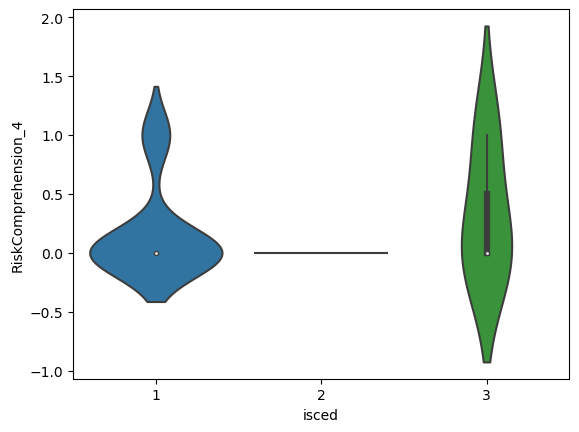

In [140]:
# Violine Plot for RiskComprehension_4 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'RiskComprehension_4')

<Axes: xlabel='isced', ylabel='GraphLiteracy_3'>

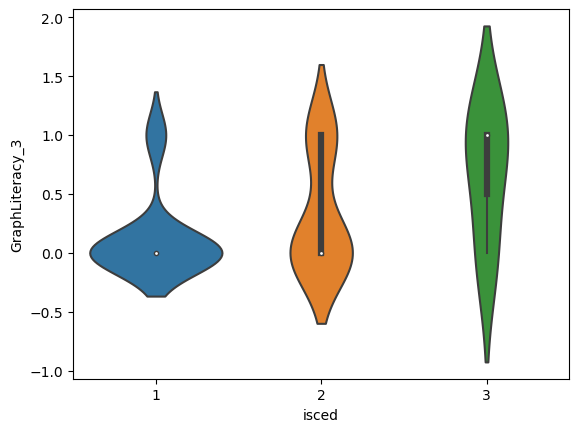

In [141]:
# Violine Plot for GraphLiteracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'GraphLiteracy_3')

<Axes: xlabel='isced', ylabel='Numeracy_3'>

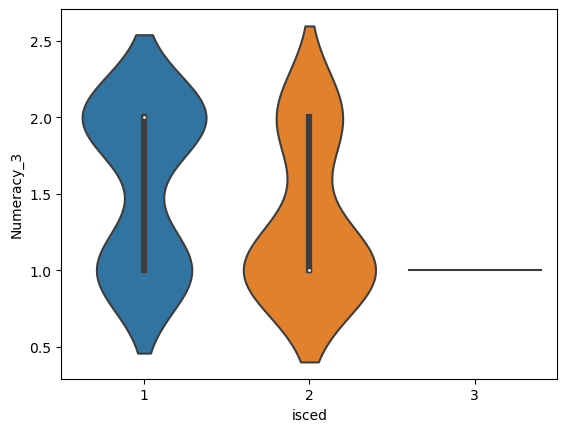

In [142]:
# Violine Plot for Numeracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Numeracy_3')

<Axes: xlabel='isced', ylabel='Bayesianreasoning_1'>

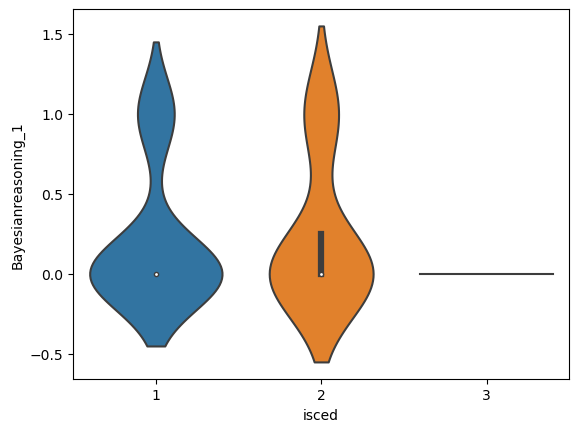

In [143]:
# Violine Plot for TotalScore_14 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Bayesianreasoning_1')

In [149]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df6 = df5.dropna(axis = 0, subset = 'wealth')
# df6.drop(df6[df6['wealth'] == 3500000].index, inplace = True)
df6.loc[df6['isced']==1][['wealth']].describe()

# temp --> remove after doing global changes
df6["wealth"] = df6["wealth"].astype(int)

In [150]:
# Descriptive stats for the data set, isced = 2

df6.loc[df6['isced']==2][['wealth']].describe()

wealth
count  1.200000e+01
mean   4.375004e+06
std    3.719018e+06
min    5.000000e+01
25%    1.375000e+06
50%    3.600000e+06
75%    7.625000e+06
max    1.000000e+07

In [151]:
# Descriptive stats for the data set, isced = 3

df6.loc[df6['isced']==3][['wealth']].describe()

wealth
count  3.000000e+00
mean   7.176667e+06
std    1.154853e+07
min    3.000000e+04
25%    5.150000e+05
50%    1.000000e+06
75%    1.075000e+07
max    2.050000e+07

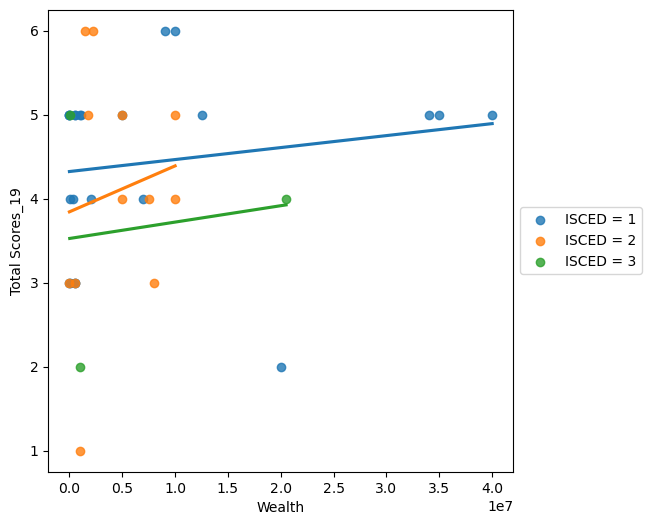

In [152]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='Wealth')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

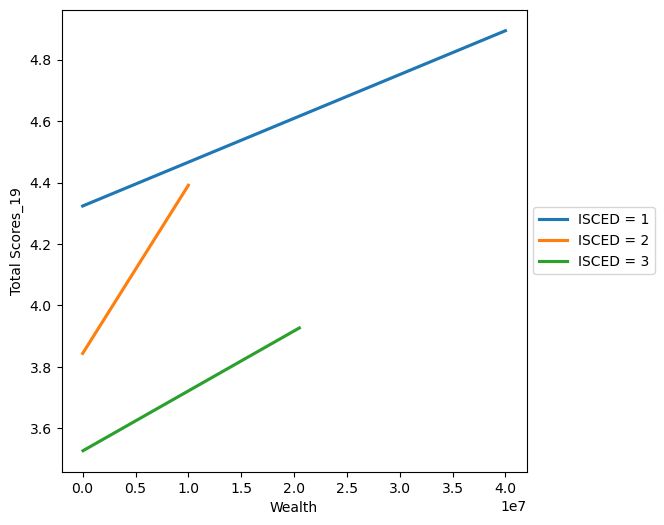

In [153]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='Wealth')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

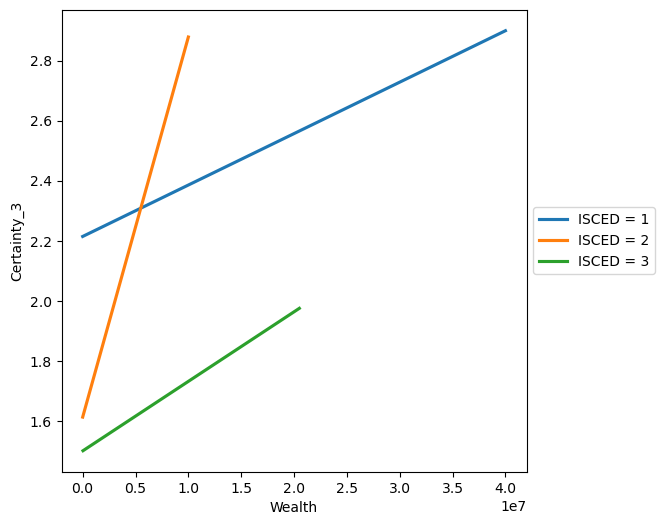

In [154]:
# Trend line for Absolute Certainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_3', xlabel='Wealth')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

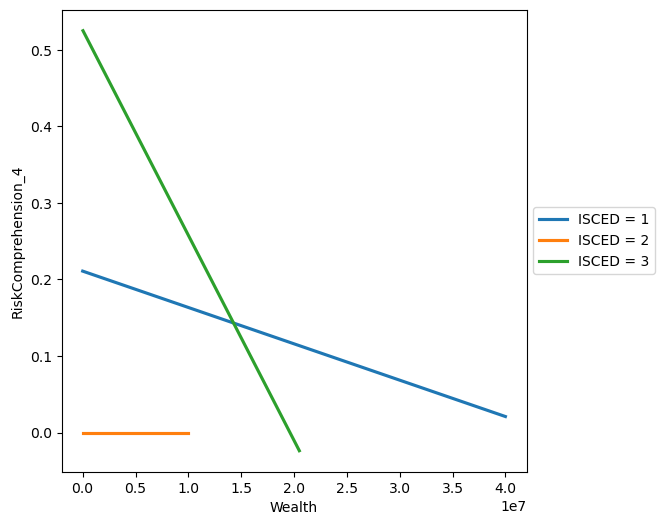

In [155]:
# Trend line for Absolute Uncertainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_4', xlabel='Wealth')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

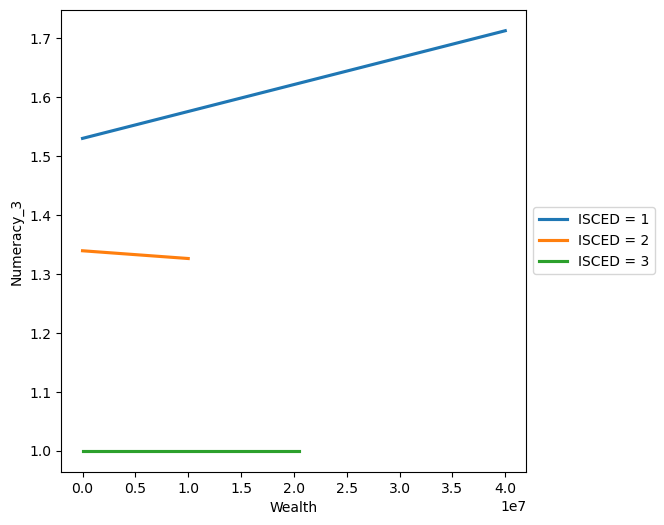

In [156]:
# Trend line for Absolute Number Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

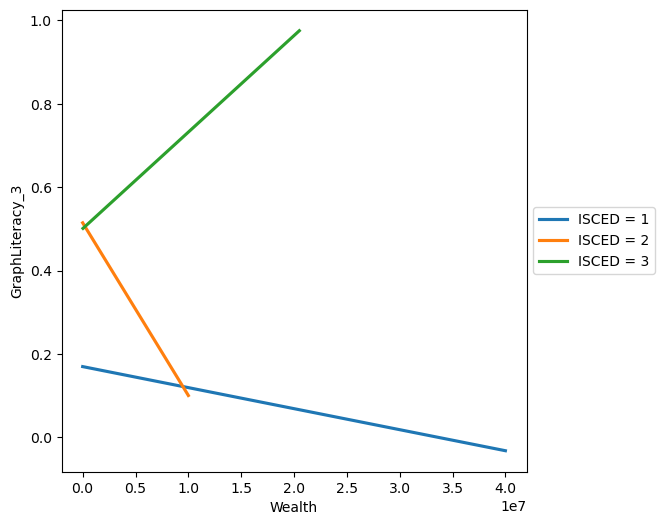

In [157]:
# Trend line for Absolute Graph Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

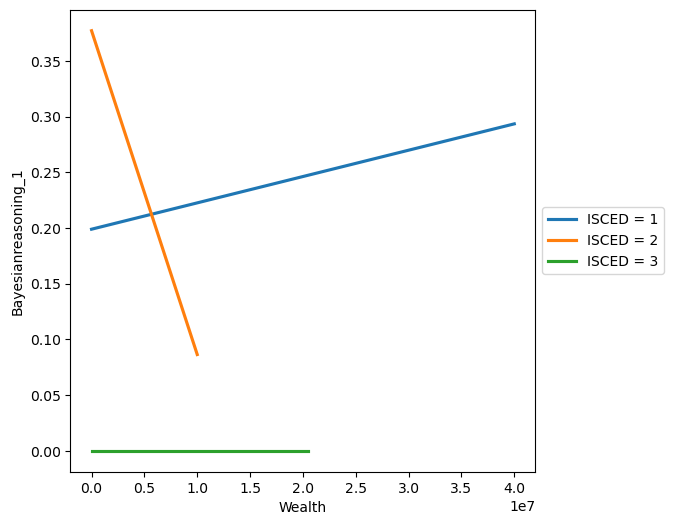

In [158]:
# Trend line for Absolute Bayesian Reasoning Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='Wealth')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [159]:
# Descriptive stats for the data set, isced = 1
# NA values of income are removed

df7 = df5
df7.drop(df7[df7['income'] == 7].index, inplace = True)

df7.loc[df7['isced']==1].describe()

age    age_rec  isced     income  Certainty_3  \
count  23.000000  23.000000   23.0  23.000000    23.000000   
mean   37.826087   2.565217    1.0   3.086957     2.347826   
std    12.496007   0.727767    0.0   1.311247     0.884652   
min    21.000000   2.000000    1.0   1.000000     0.000000   
25%    29.000000   2.000000    1.0   2.000000     2.000000   
50%    34.000000   2.000000    1.0   3.000000     3.000000   
75%    44.500000   3.000000    1.0   4.000000     3.000000   
max    65.000000   4.000000    1.0   6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            23.000000        23.000000   23.000000            23.000000   
mean              0.173913         0.130435    1.565217             0.217391   
std               0.387553         0.344350    0.506870             0.421741   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    2.000000             0.000000   
75%               0.000000         0.000000    2.000000             0.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    23.000000            23.000000        23.000000   23.000000   
mean     78.260870             4.347826         4.347826   52.173913   
std      29.488391             9.688835        11.478341   16.895660   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%     100.000000             0.000000         0.000000   66.666667   
75%     100.000000             0.000000         0.000000   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            23.000000      23.000000     23.000000  
mean             21.739130       4.434783     31.677019  
std              42.174117       1.036870      7.406212  
min               0.000000       2.000000     14.285714  
25%               0.000000       4.000000     28.571429  
50%               0.000000       5.000000     35.714286  
75%               0.000000       5.000000     35.714286  
max             100.000000       6.000000     42.857143

In [160]:
df7.loc[df7['isced']==2].describe()

age    age_rec  isced     income  Certainty_3  \
count  12.000000  12.000000   12.0  12.000000    12.000000   
mean   44.000000   2.916667    2.0   2.000000     2.166667   
std    14.365362   0.792961    0.0   0.852803     1.029857   
min    25.000000   2.000000    2.0   1.000000     0.000000   
25%    31.750000   2.000000    2.0   1.000000     1.750000   
50%    42.500000   3.000000    2.0   2.000000     2.500000   
75%    53.000000   3.250000    2.0   3.000000     3.000000   
max    65.000000   4.000000    2.0   3.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count                 12.0        12.000000   12.000000            12.000000   
mean                   0.0         0.333333    1.333333             0.250000   
std                    0.0         0.492366    0.492366             0.452267   
min                    0.0         0.000000    1.000000             0.000000   
25%                    0.0         0.000000    1.000000             0.000000   
50%                    0.0         0.000000    1.000000             0.000000   
75%                    0.0         1.000000    2.000000             0.250000   
max                    0.0         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    12.000000                 12.0        12.000000   12.000000   
mean     72.222222                  0.0        11.111111   44.444444   
std      34.328577                  0.0        16.412199   16.412199   
min       0.000000                  0.0         0.000000   33.333333   
25%      58.333333                  0.0         0.000000   33.333333   
50%      83.333333                  0.0         0.000000   33.333333   
75%     100.000000                  0.0        33.333333   66.666667   
max     100.000000                  0.0        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            12.000000      12.000000     12.000000  
mean             25.000000       4.083333     29.166667  
std              45.226702       1.443376     10.309826  
min               0.000000       1.000000      7.142857  
25%               0.000000       3.000000     21.428571  
50%               0.000000       4.000000     28.571429  
75%              25.000000       5.000000     35.714286  
max             100.000000       6.000000     42.857143

In [161]:
df7.loc[df7['isced']==3].describe()

age  age_rec  isced    income  Certainty_3  RiskComprehension_4  \
count   3.000000      3.0    3.0  3.000000     3.000000             3.000000   
mean   25.000000      2.0    3.0  3.000000     1.666667             0.333333   
std     8.717798      0.0    0.0  2.645751     0.577350             0.577350   
min    19.000000      2.0    3.0  1.000000     1.000000             0.000000   
25%    20.000000      2.0    3.0  1.500000     1.500000             0.000000   
50%    21.000000      2.0    3.0  2.000000     2.000000             0.000000   
75%    28.000000      2.0    3.0  4.000000     2.000000             0.500000   
max    35.000000      2.0    3.0  6.000000     2.000000             1.000000   

       GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  Certainty_%  \
count         3.000000         3.0                  3.0     3.000000   
mean          0.666667         1.0                  0.0    55.555556   
std           0.577350         0.0                  0.0    19.245009   
min           0.000000         1.0                  0.0    33.333333   
25%           0.500000         1.0                  0.0    50.000000   
50%           1.000000         1.0                  0.0    66.666667   
75%           1.000000         1.0                  0.0    66.666667   
max           1.000000         1.0                  0.0    66.666667   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count             3.000000         3.000000    3.000000                  3.0   
mean              8.333333        22.222222   33.333333                  0.0   
std              14.433757        19.245009    0.000000                  0.0   
min               0.000000         0.000000   33.333333                  0.0   
25%               0.000000        16.666667   33.333333                  0.0   
50%               0.000000        33.333333   33.333333                  0.0   
75%              12.500000        33.333333   33.333333                  0.0   
max              25.000000        33.333333   33.333333                  0.0   

       TotalScore_14  TotalScore_%  
count       3.000000      3.000000  
mean        3.666667     26.190476  
std         1.527525     10.910895  
min         2.000000     14.285714  
25%         3.000000     21.428571  
50%         4.000000     28.571429  
75%         4.500000     32.142857  
max         5.000000     35.714286

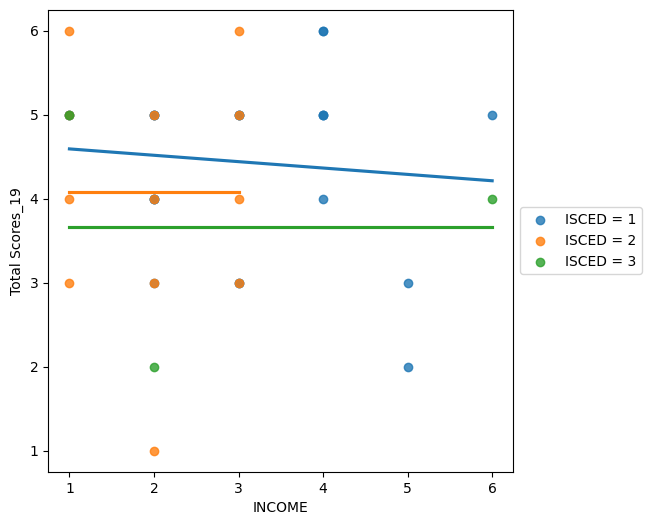

In [162]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==1]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==2]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==3]['TotalScore_14'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='INCOME')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

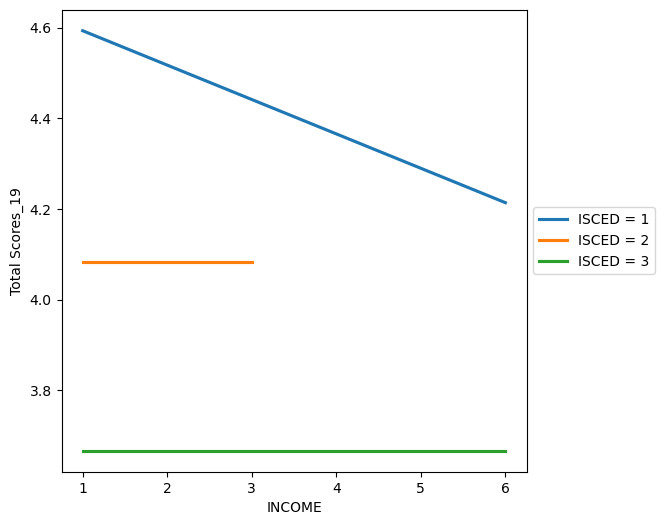

In [163]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'TotalScore_14', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='INCOME')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

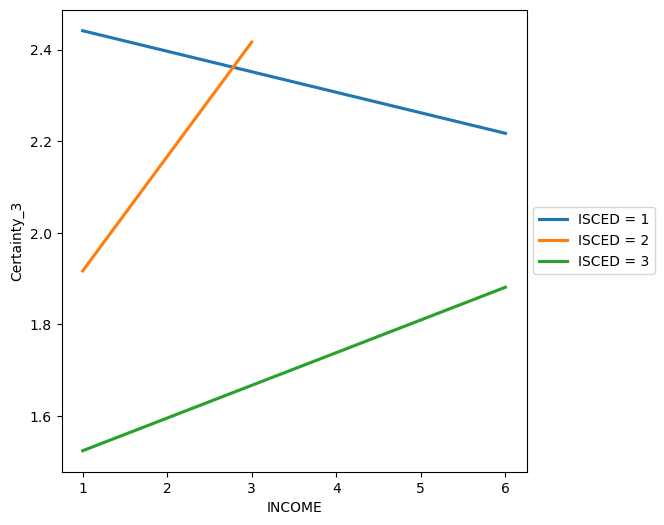

In [164]:
# Trend line for Absolute Certainty Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Certainty_3', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_3', xlabel='INCOME')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

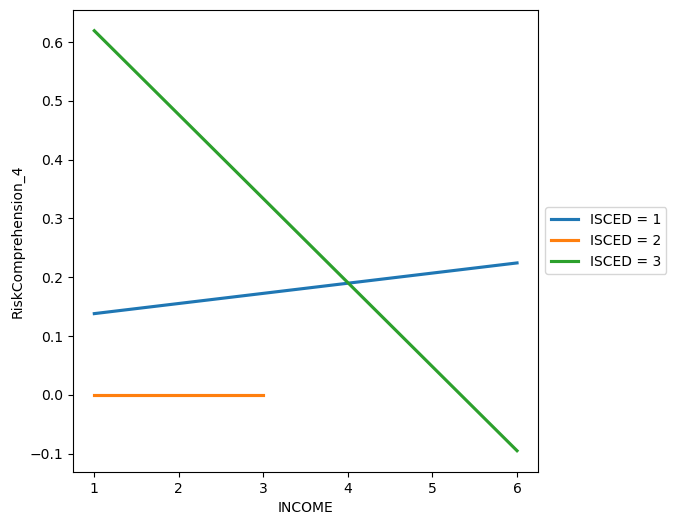

In [165]:
# Trend line for Absolute Risk Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'RiskComprehension_4', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_4', xlabel='INCOME')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

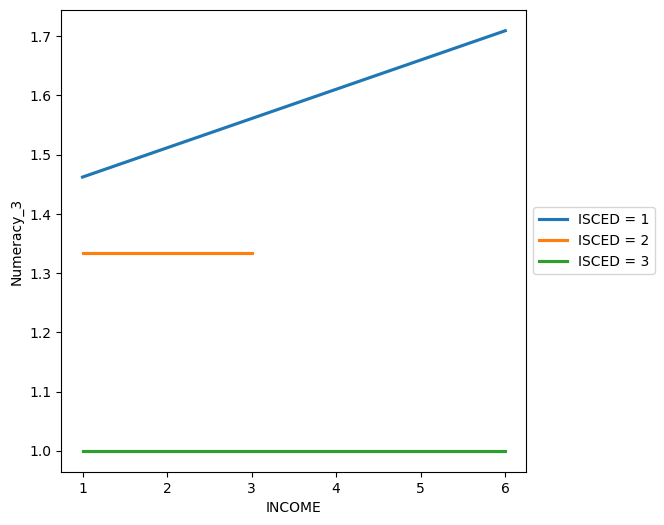

In [166]:
# Trend line for Absolute Number Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Numeracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

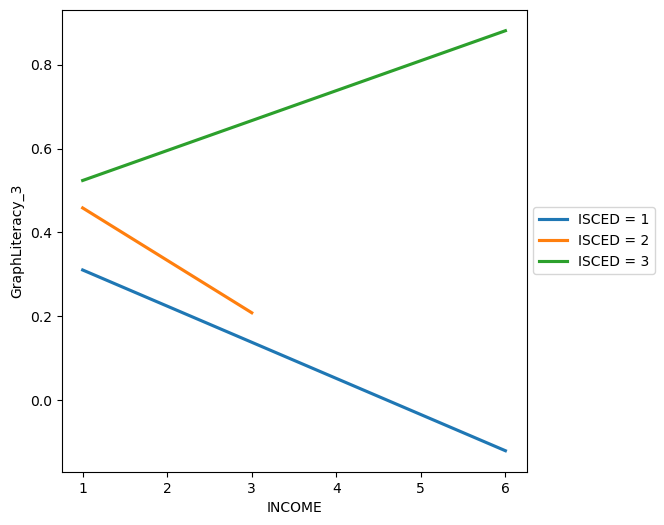

In [167]:
# Trend line for Absolute Graph Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

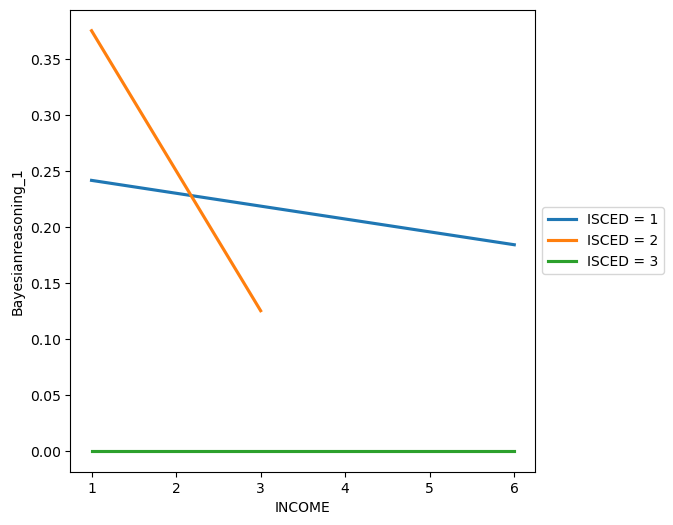

In [168]:
# Trend line for Absolute Bayesian Reasoning Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='INCOME')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [169]:
df7

ResponseId  age  age_rec  isced  income    wealth  Certainty_3  \
0   R_2dh1JGHNy9Qf3Sc   27        2      1       5    560000            2   
1   R_9WK1oFSxYtmb82d   26        2      1       2   2000000            1   
2   R_9OjW44KK2eoxYq6   25        2      1       3         0            0   
3   R_9OVVcpK6sOQlOIS   29        2      1       2    500000            3   
4   R_9CE2lLvpyPaeyKL   30        2      1       2   5000000            2   
5   R_97I7fCImWYfF0c1   37        3      1       4  10000000            3   
6   R_94RdOE5ZgRNG4EN   34        2      1       2    300000            2   
7   R_4rqHwH5DM0AMTLj   29        2      1       3         1            3   
8   R_4lz68e8z2NuRRnB   65        4      1       1      2000            3   
9   R_4lhh2fUgLjRDBoW   37        3      1       4    500000            3   
10  R_4lEUpdznwWtpRu1   57        4      1       3    100000            1   
11  R_4iP9ZyO9BmRTMnR   53        3      1       4   9000000            3   
12  R_4gbu4eNareZsG1n   51        3      1       2    100000            3   
13  R_4fklajzbcuU4NST   29        2      1       2       100            3   
14  R_4hmcVnKZPIvDOa7   42        3      1       4   1000000            2   
15  R_9vdhG8DvdLvRPJ3   30        2      1       6  12500000            3   
16  R_4ILQ6jRhbVna8kN   31        2      1       3  35000000            3   
17  R_3QLPNhaVQBnJsSe   45        3      1       3  34000000            3   
18  R_4FsteJ71URQ4F4U   34        2      1       4   7000000            2   
19  R_4Dvu7ZttFgPENwR   63        4      1       1   1100000            3   
20  R_40GWAL4WdQi5VAS   44        3      1       4  40000000            3   
21  R_4McIMWBwCH9AFnv   21        2      1       2    500000            2   
22  R_4AY9PEqIAgaYkuZ   31        2      1       5  20000000            1   
23  R_9pbaa1ht3gisbyT   47        3      2       1   5000000            2   
24  R_2jiyT9teVIVHpQy   25        2      2       3  10000000            3   
25  R_37jpqSSD0cmMBQQ   65        4      2       2   7500000            2   
26  R_9KkHAUQVKsGiBhe   26        2      2       3   1500000            3   
27  R_9DO5s0JxPsoShVq   65        4      2       2   1000000            0   
28  R_4efA0IivV0kgbW4   43        3      2       1   2200000            3   
29  R_93a68YKbkrwr9yI   62        4      2       1   5000000            3   
30  R_4ziRnglDZQo2B0t   40        3      2       2   1800000            3   
31  R_4CyH4vrwFkIMDVD   31        2      2       2    500000            1   
32  R_4GJIH6GbqzLPmEv   50        3      2       1        50            1   
33  R_4IaSxXGv1CohFKJ   32        2      2       3   8000000            2   
34  R_93k9HjrDvW0Xd4d   42        3      2       3  10000000            3   
35  R_9s10NPIoxiHRAkx   21        2      3       1     30000            2   
36  R_4L6m1FU0Ujmh3V7   19        2      3       2   1000000            1   
37  R_4176twZZuUqgV9m   35        2      3       6  20500000            2   

    RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
0                     0                0           1                    0   
1                     0                0           2                    1   
2                     1                0           2                    0   
3                     0                0           2                    0   
4                     1                1           1                    0   
5                     0                0           2                    1   
6                     0                0           2                    0   
7                     0                0           2                    0   
8                     0                0           2                    0   
9                     0                0           2                    0   
10                    0                1           1                    0   
11                    1                0           2                    0   
12    

In [170]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [171]:
df7.loc[(df7['age_rec']==2)].describe()

age  age_rec      isced     income  Certainty_3  \
count  20.000000     20.0  20.000000  20.000000    20.000000   
mean   28.250000      2.0   1.500000   3.050000     2.050000   
std     4.470665      0.0   0.760886   1.431782     0.887041   
min    19.000000      2.0   1.000000   1.000000     0.000000   
25%    25.750000      2.0   1.000000   2.000000     1.750000   
50%    29.000000      2.0   1.000000   3.000000     2.000000   
75%    31.000000      2.0   2.000000   3.250000     3.000000   
max    35.000000      2.0   3.000000   6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            20.000000        20.000000   20.000000            20.000000   
mean              0.150000         0.200000    1.500000             0.150000   
std               0.366348         0.410391    0.512989             0.366348   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.500000             0.000000   
75%               0.000000         0.000000    2.000000             0.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    20.000000            20.000000        20.000000   20.000000   
mean     68.333333             3.750000         6.666667   50.000000   
std      29.568040             9.158689        13.679711   17.099639   
min       0.000000             0.000000         0.000000   33.333333   
25%      58.333333             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   50.000000   
75%     100.000000             0.000000         0.000000   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            20.000000      20.000000     20.000000  
mean             15.000000       4.050000     28.928571  
std              36.634755       1.145931      8.185222  
min               0.000000       2.000000     14.285714  
25%               0.000000       3.000000     21.428571  
50%               0.000000       4.000000     28.571429  
75%               0.000000       5.000000     35.714286  
max             100.000000       6.000000     42.857143

In [172]:
df7.loc[(df7['age_rec']==3)].describe()

age  age_rec      isced     income  Certainty_3  \
count  12.000000     12.0  12.000000  12.000000    12.000000   
mean   44.250000      3.0   1.416667   2.750000     2.666667   
std     5.207076      0.0   0.514929   1.288057     0.651339   
min    37.000000      3.0   1.000000   1.000000     1.000000   
25%    41.500000      3.0   1.000000   1.750000     2.750000   
50%    43.500000      3.0   1.000000   3.000000     3.000000   
75%    47.750000      3.0   2.000000   4.000000     3.000000   
max    53.000000      3.0   2.000000   4.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            12.000000        12.000000   12.000000            12.000000   
mean              0.166667         0.166667    1.500000             0.333333   
std               0.389249         0.389249    0.522233             0.492366   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.500000             0.000000   
75%               0.000000         0.000000    2.000000             1.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    12.000000            12.000000        12.000000   12.000000   
mean     88.888889             4.166667         5.555556   50.000000   
std      21.711298             9.731237        12.974982   17.407766   
min      33.333333             0.000000         0.000000   33.333333   
25%      91.666667             0.000000         0.000000   33.333333   
50%     100.000000             0.000000         0.000000   50.000000   
75%     100.000000             0.000000         0.000000   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            12.000000      12.000000     12.000000  
mean             33.333333       4.833333     34.523810  
std              49.236596       0.937437      6.695978  
min               0.000000       3.000000     21.428571  
25%               0.000000       4.000000     28.571429  
50%               0.000000       5.000000     35.714286  
75%             100.000000       5.250000     37.500000  
max             100.000000       6.000000     42.857143

In [173]:
df7.loc[(df7['age_rec']==4)].describe()

age  age_rec     isced    income  Certainty_3  \
count   6.000000      6.0  6.000000  6.000000     6.000000   
mean   62.833333      4.0  1.500000  1.666667     2.000000   
std     3.125167      0.0  0.547723  0.816497     1.264911   
min    57.000000      4.0  1.000000  1.000000     0.000000   
25%    62.250000      4.0  1.000000  1.000000     1.250000   
50%    64.000000      4.0  1.500000  1.500000     2.500000   
75%    65.000000      4.0  2.000000  2.000000     3.000000   
max    65.000000      4.0  2.000000  3.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count                  6.0         6.000000    6.000000             6.000000   
mean                   0.0         0.500000    1.166667             0.166667   
std                    0.0         0.547723    0.408248             0.408248   
min                    0.0         0.000000    1.000000             0.000000   
25%                    0.0         0.000000    1.000000             0.000000   
50%                    0.0         0.500000    1.000000             0.000000   
75%                    0.0         1.000000    1.000000             0.000000   
max                    0.0         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count     6.000000                  6.0         6.000000    6.000000   
mean     66.666667                  0.0        16.666667   38.888889   
std      42.163702                  0.0        18.257419   13.608276   
min       0.000000                  0.0         0.000000   33.333333   
25%      41.666667                  0.0         0.000000   33.333333   
50%      83.333333                  0.0        16.666667   33.333333   
75%     100.000000                  0.0        33.333333   33.333333   
max     100.000000                  0.0        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count             6.000000       6.000000      6.000000  
mean             16.666667       3.833333     27.380952  
std              40.824829       1.602082     11.443443  
min               0.000000       1.000000      7.142857  
25%               0.000000       3.250000     23.214286  
50%               0.000000       4.500000     32.142857  
75%               0.000000       5.000000     35.714286  
max             100.000000       5.000000     35.714286

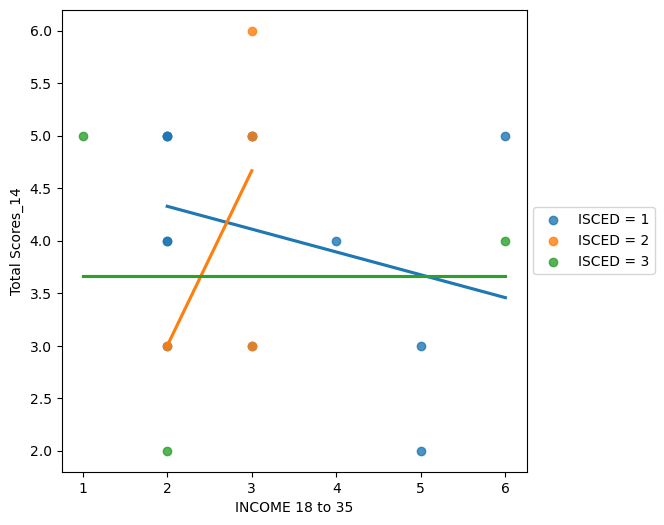

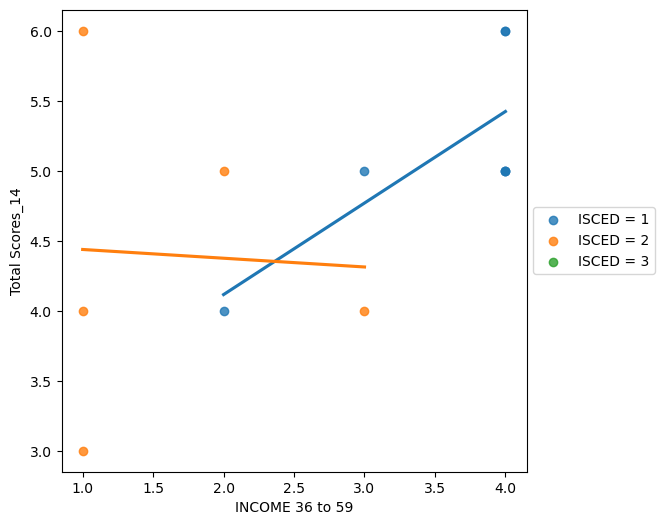

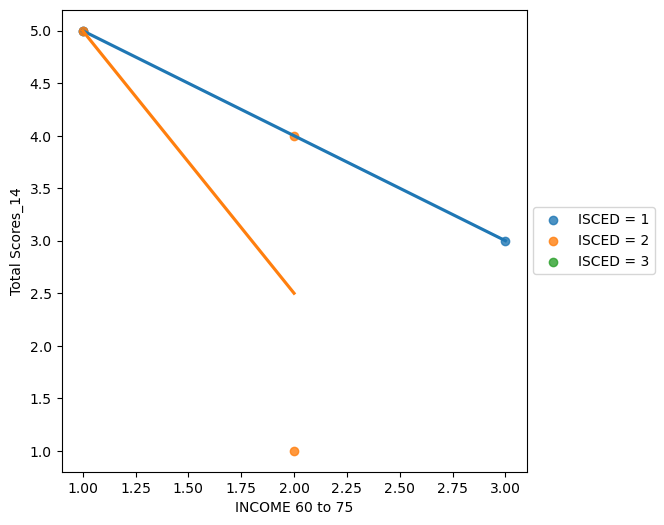

In [174]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='INCOME 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME 36 to 59')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME 60 to 75')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

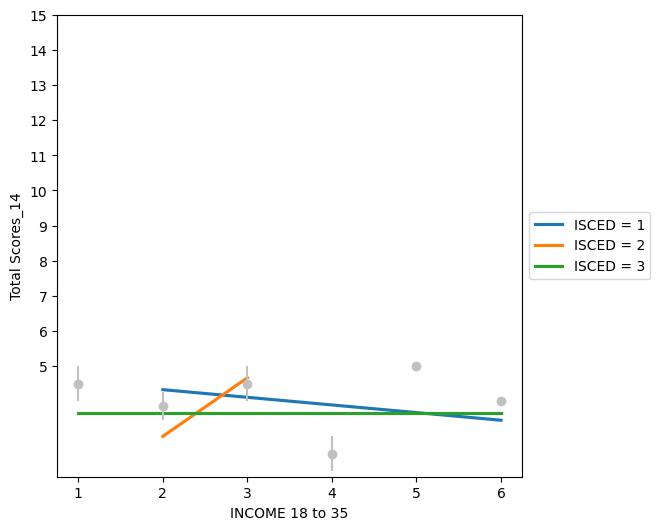

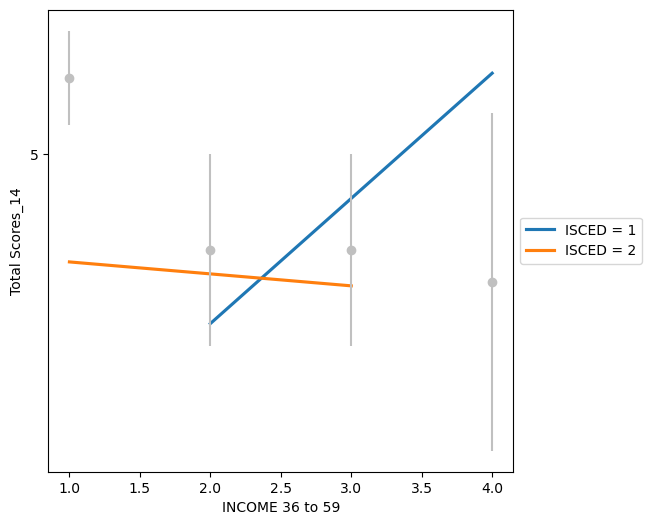

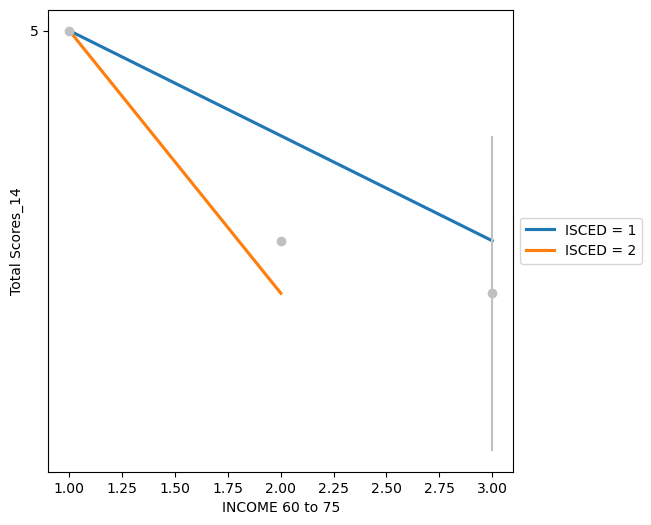

In [175]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='INCOME 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME 36 to 59',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME 60 to 75',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income']).mean(numeric_only=True)['TotalScore_14'], yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

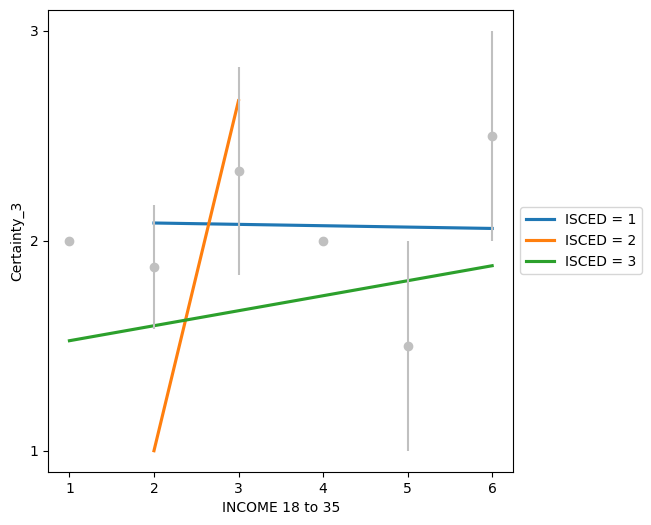

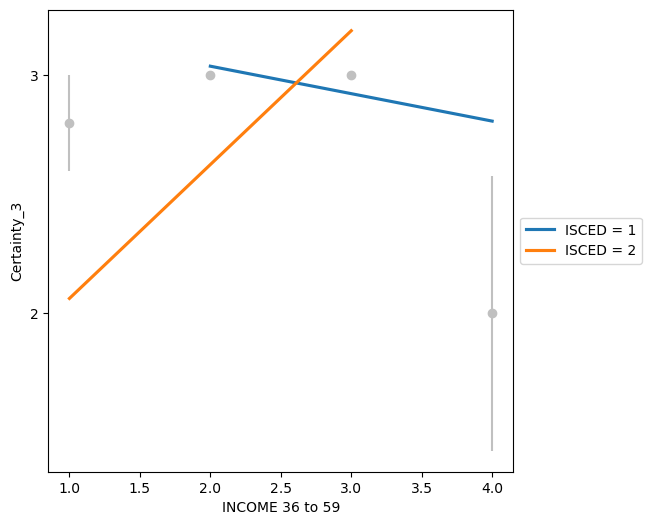

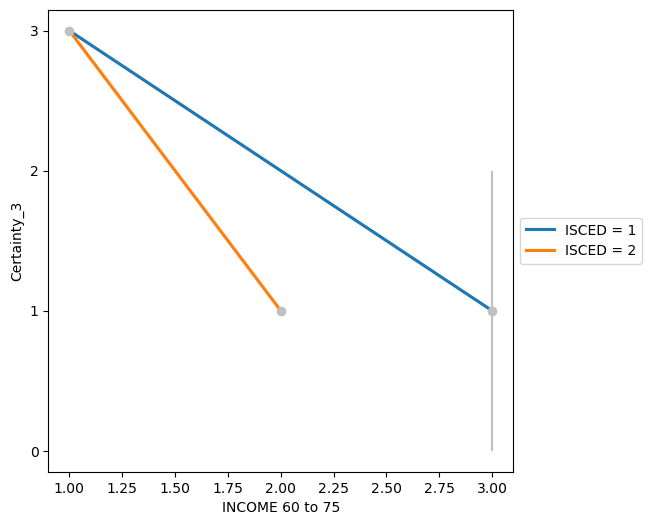

In [178]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']== 3 ]['income'].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

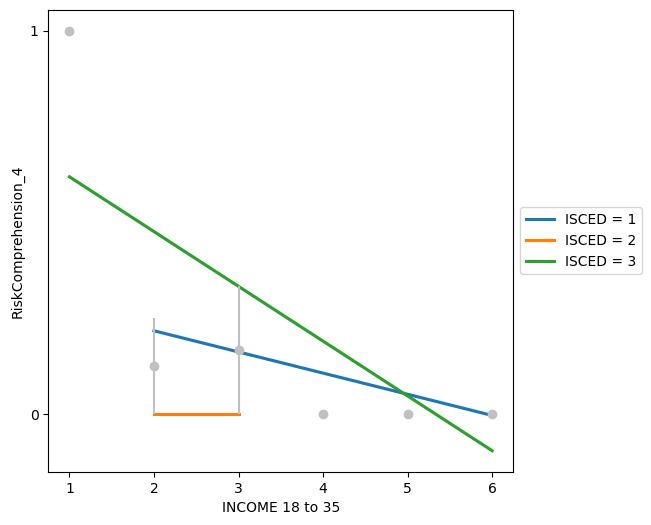

ValueError: 'x' and 'y' must have the same size

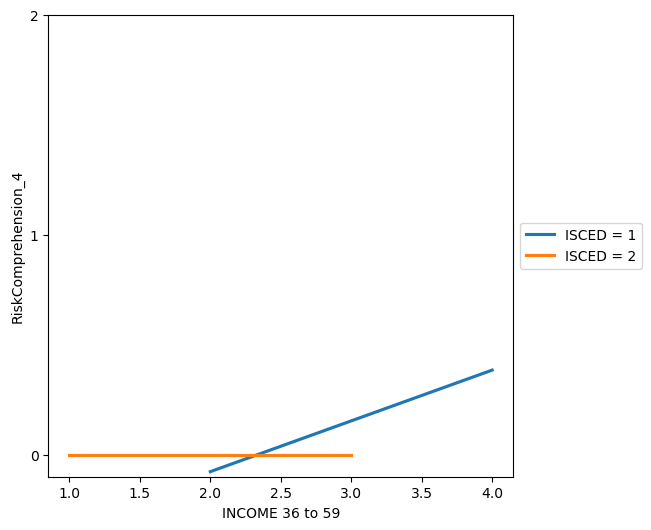

In [179]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_4', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_4', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_4', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

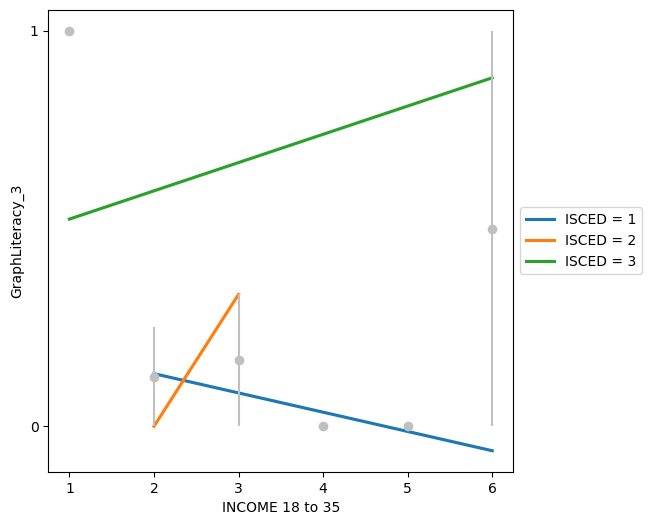

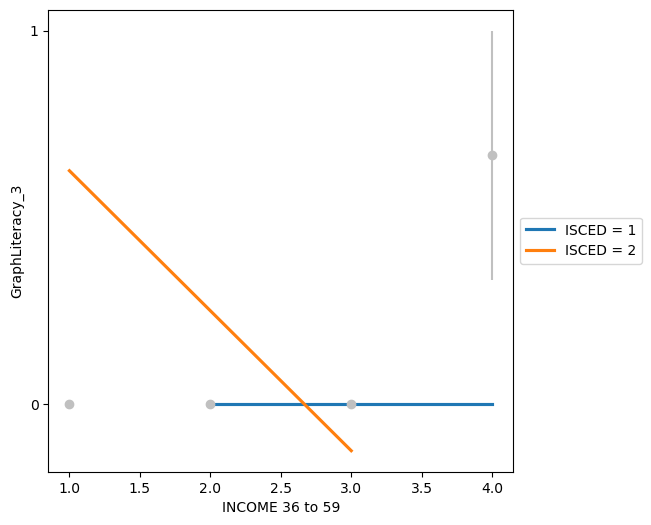

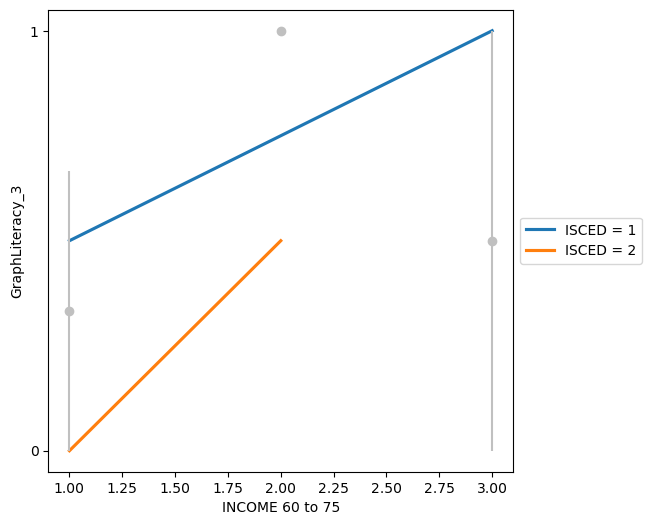

In [182]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']== 3 ]['income'].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

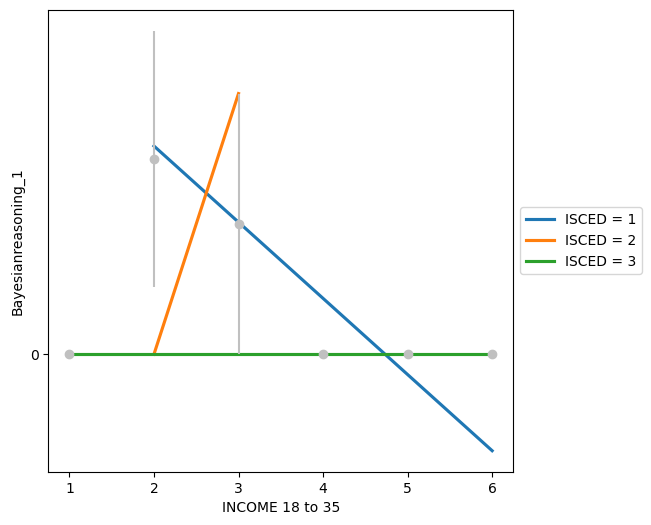

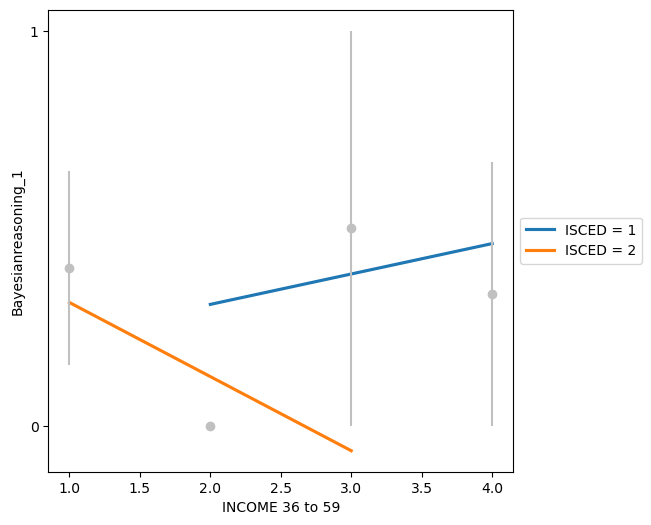

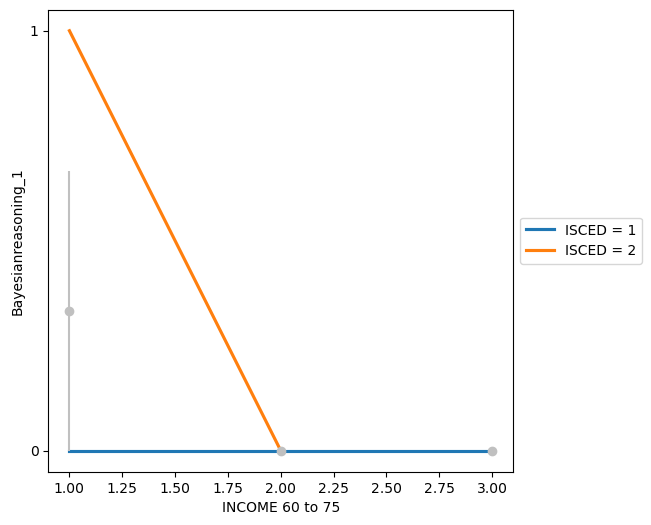

In [184]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 36 to 59',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']== 3 ]['income'].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='INCOME 60 to 75',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [185]:
# Age median method
# Age_median

In [186]:
age_m = df1["age"].median()
age_m

34.5

In [187]:
df7["income"].value_counts()

income
2    12
3     9
1     7
4     6
5     2
6     2
Name: count, dtype: int64

In [188]:
df7.loc[(df7['age'] < age_m)].describe()

age  age_rec      isced     income  Certainty_3  \
count  19.000000     19.0  19.000000  19.000000    19.000000   
mean   27.894737      2.0   1.421053   2.894737     2.052632   
std     4.293338      0.0   0.692483   1.286457     0.911268   
min    19.000000      2.0   1.000000   1.000000     0.000000   
25%    25.500000      2.0   1.000000   2.000000     1.500000   
50%    29.000000      2.0   1.000000   3.000000     2.000000   
75%    31.000000      2.0   2.000000   3.000000     3.000000   
max    34.000000      2.0   3.000000   6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            19.000000        19.000000   19.000000            19.000000   
mean              0.157895         0.157895    1.526316             0.157895   
std               0.374634         0.374634    0.512989             0.374634   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    2.000000             0.000000   
75%               0.000000         0.000000    2.000000             0.000000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    19.000000            19.000000        19.000000   19.000000   
mean     68.421053             3.947368         5.263158   50.877193   
std      30.375600             9.365858        12.487811   17.099639   
min       0.000000             0.000000         0.000000   33.333333   
25%      50.000000             0.000000         0.000000   33.333333   
50%      66.666667             0.000000         0.000000   66.666667   
75%     100.000000             0.000000         0.000000   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            19.000000      19.000000     19.000000  
mean             15.789474       4.052632     28.947368  
std              37.463432       1.177270      8.409072  
min               0.000000       2.000000     14.285714  
25%               0.000000       3.000000     21.428571  
50%               0.000000       4.000000     28.571429  
75%               0.000000       5.000000     35.714286  
max             100.000000       6.000000     42.857143

In [189]:
df7.loc[(df7['age'] > age_m)].describe()

age    age_rec      isced     income  Certainty_3  \
count  19.000000  19.000000  19.000000  19.000000    19.000000   
mean   49.631579   3.263158   1.526316   2.578947     2.421053   
std    10.420122   0.561951   0.611775   1.464991     0.901591   
min    35.000000   2.000000   1.000000   1.000000     0.000000   
25%    42.000000   3.000000   1.000000   1.000000     2.000000   
50%    47.000000   3.000000   1.000000   2.000000     3.000000   
75%    59.500000   4.000000   2.000000   4.000000     3.000000   
max    65.000000   4.000000   3.000000   6.000000     3.000000   

       RiskComprehension_4  GraphLiteracy_3  Numeracy_3  Bayesianreasoning_1  \
count            19.000000        19.000000   19.000000            19.000000   
mean              0.105263         0.315789    1.368421             0.263158   
std               0.315302         0.477567    0.495595             0.452414   
min               0.000000         0.000000    1.000000             0.000000   
25%               0.000000         0.000000    1.000000             0.000000   
50%               0.000000         0.000000    1.000000             0.000000   
75%               0.000000         1.000000    2.000000             0.500000   
max               1.000000         1.000000    2.000000             1.000000   

       Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count    19.000000            19.000000        19.000000   19.000000   
mean     80.701754             2.631579        10.526316   45.614035   
std      30.053018             7.882544        15.918898   16.519821   
min       0.000000             0.000000         0.000000   33.333333   
25%      66.666667             0.000000         0.000000   33.333333   
50%     100.000000             0.000000         0.000000   33.333333   
75%     100.000000             0.000000        33.333333   66.666667   
max     100.000000            25.000000        33.333333   66.666667   

       Bayesianreasoning_%  TotalScore_14  TotalScore_%  
count            19.000000      19.000000     19.000000  
mean             26.315789       4.473684     31.954887  
std              45.241393       1.218762      8.705441  
min               0.000000       1.000000      7.142857  
25%               0.000000       4.000000     28.571429  
50%               0.000000       5.000000     35.714286  
75%              50.000000       5.000000     35.714286  
max             100.000000       6.000000     42.857143

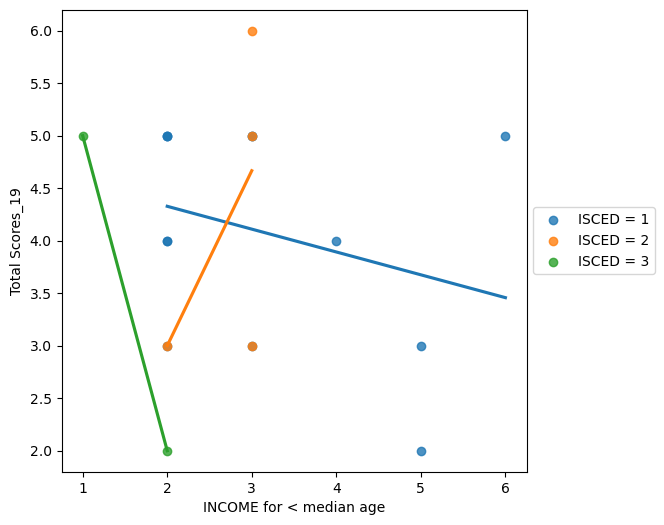

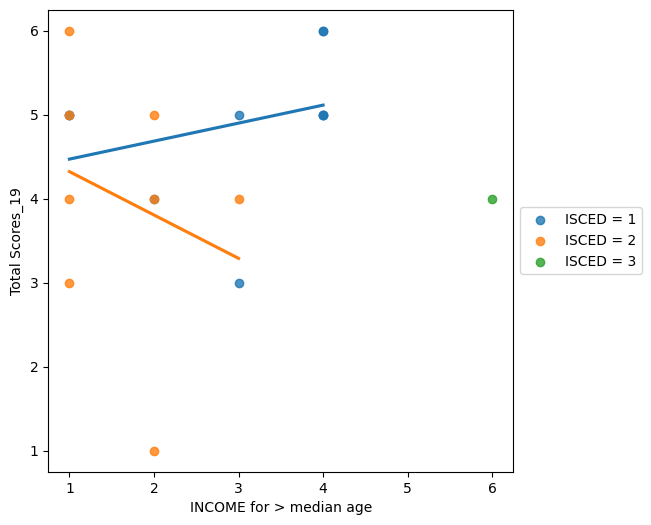

In [190]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='INCOME for > median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

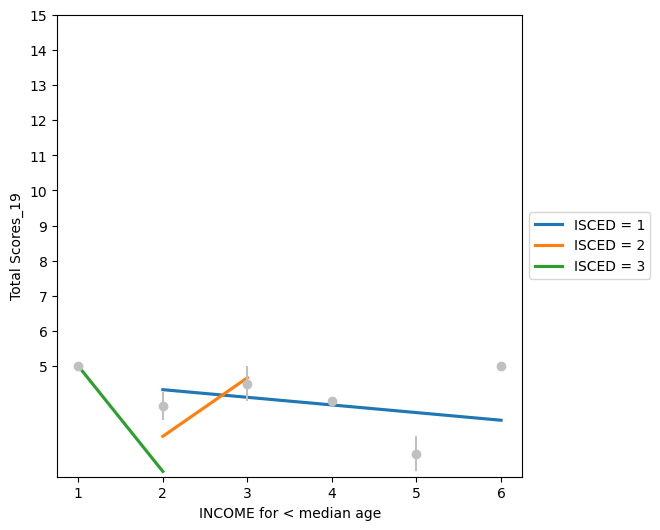

ValueError: 'x' and 'y' must have the same size

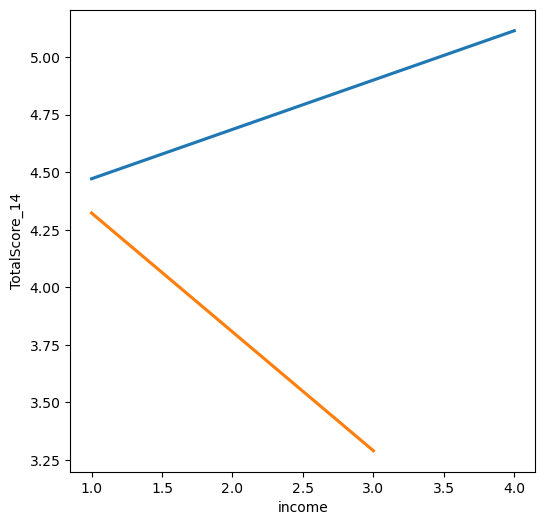

In [191]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['TotalScore_14'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['TotalScore_14'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['TotalScore_14'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='INCOME for > median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Certainty_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Certainty_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Certainty_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_3', xlabel='INCOME for > median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_4', xlabel='INCOME for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['RiskComprehension_4'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['RiskComprehension_4'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['RiskComprehension_4'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_4', xlabel='INCOME for > median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Numeracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Numeracy_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Numeracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_3', xlabel='INCOME for > median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for > median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] > age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = [1,2,3,4,5,6], y = df7.loc[ (df7['age'] > age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] > age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for > median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()